## Sommaire

* [Importation des librairies](#import)


* [Chargement des bases de données](#chargement)


* [1. Analyse préliminaire des données d'origine](#analyse_prélim)


* [2. Jointure extérieure des tables](#jointure)


* [3. Nettoyage des données](#nettoyage)


* [4. Analyse des données](#analyse)

    - [4.1 Les périodes d'achat](#date_achat)
    
    - [4.2 Montants des paniers](#montants_paniers)
    
    - [4.3 Montants dépensés par les clients](#montants_clients)
    
    - [4.4 Volume des achats](#volume_achats)
    
    - [4.5 La popularité des produits](#popularité_produits)
    
    - [4.6 Mesures de concentration](#mesures_concentration)
    
    - [4.7 La catégorie des produits et le sexe des clients](#categ_sexe_clients)
    
    - [4.8 L'âge des clients et le montant total des achats](#montant_total_age)
    
    - [4.9 Le montant des paniers et l'âge des clients](#paniers_age)
    
    - [4.10 L'âge des clients et la catégorie des produits](#categ_age)
    


## Importation des librairies <a class='anchor' id='import'></a>

In [1]:
import math
import collections
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Chargement des bases de données <a class='anchor' id='chargement'></a>

In [2]:
ventes = pd.read_csv('data/transactions.csv')
clients = pd.read_csv('data/customers.csv')
produits = pd.read_csv('data/products.csv')

## 1. Analyse préliminaire des données d'origine <a class='anchor' id='analyse_prélim'></a>

#### 1.1 DataFrame 'ventes'

In [3]:
ventes.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


In [4]:
ventes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
id_prod       337016 non-null object
date          337016 non-null object
session_id    337016 non-null object
client_id     337016 non-null object
dtypes: object(4)
memory usage: 10.3+ MB


#### 1.2 DataFrame 'clients'

In [5]:
clients.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [6]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
client_id    8623 non-null object
sex          8623 non-null object
birth        8623 non-null int64
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


#### Identification des variables de la colonne 'sex'

In [7]:
clients.sex.unique()

array(['f', 'm'], dtype=object)

In [8]:
clients.sex.value_counts()

f    4491
m    4132
Name: sex, dtype: int64

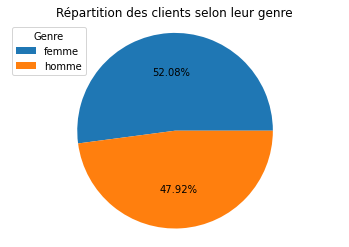

In [7]:
# Graphique en camembert de la répartition des clients selon leur genre
plt.pie(clients.sex.value_counts(), autopct='%.2f%%')
plt.axis('equal')
plt.title('Répartition des clients selon leur genre')
plt.legend(['femme', 'homme'], title='Genre', loc='upper left', fontsize=10)
plt.show()

#### Identification des clients selon leur année de naissance

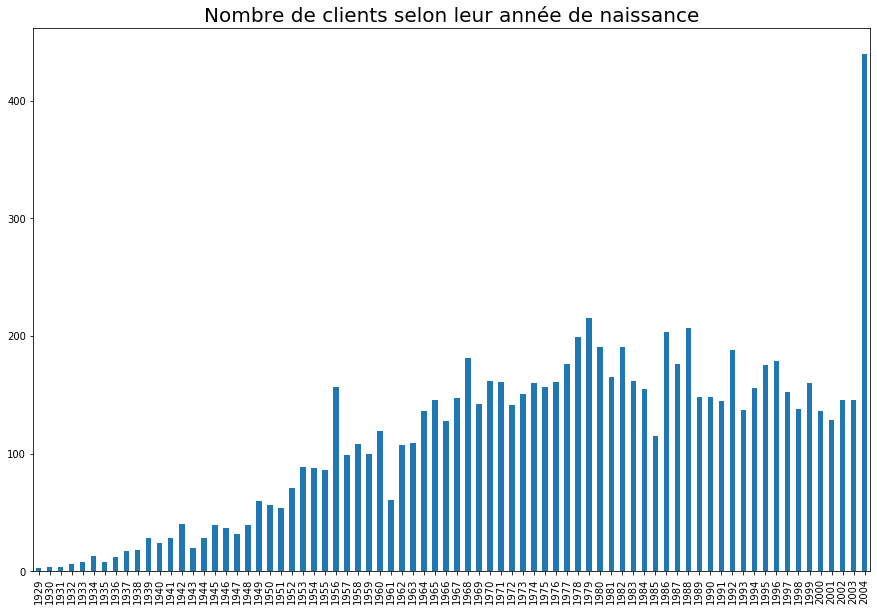

In [10]:
# Graphique en barre énumérant les clients selon leur année de naissance
plt.figure(figsize=(15,10))
clients['birth'].value_counts().sort_index().plot(kind='bar')
plt.title('Nombre de clients selon leur année de naissance', fontsize=20)
plt.show()

In [11]:
clients.birth.value_counts()

2004    440
1979    215
1988    207
1986    203
1978    199
       ... 
1935      8
1932      6
1931      4
1930      4
1929      3
Name: birth, Length: 76, dtype: int64

In [12]:
annee_client = clients.groupby('birth').count()
annee_client[['client_id']].sort_values(by='client_id', ascending=False)

,client_id
birth,
2004,440
1979,215
1988,207
1986,203
1978,199
...,...
1935,8
1932,6
1931,4


On constate une nette sur-représentation des clients nés en 2004. Cette singularité suggère plusieurs possibilités: 
- un certain nombre de clients mineurs ont déclaré avoir 18 ans afin d'être autorisés à faire un achat en ligne. 
- les clients ont enregistré dans le formulaire l'année de naissance proposée par défaut.

#### 1.3 DataFrame 'produits'

In [13]:
produits.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


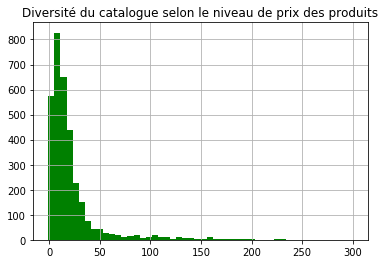

In [14]:
produits['price'].hist(bins=50, facecolor='green')
plt.title('Diversité du catalogue selon le niveau de prix des produits')
plt.savefig("Nombre de produits du catalogue selon leur prix.png")
plt.show()

In [15]:
produits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
id_prod    3287 non-null object
price      3287 non-null float64
categ      3287 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


#### Diversité des produits selon leur catégorie

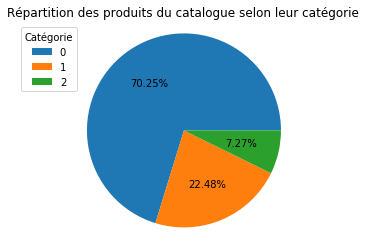

In [16]:
plt.pie(produits.categ.value_counts(), autopct='%.2f%%')
plt.axis('equal')
plt.title('Répartition des produits du catalogue selon leur catégorie')
plt.legend([0,1,2], title='Catégorie', loc='upper left', fontsize=10)
plt.savefig("Diversité des produits selon leur catégorie.png")
plt.show()

#### Identification des produits de catégorie 2

In [17]:
id_prod_cat2 = produits.loc[produits.categ == 2]
id_prod_cat2.sort_values(by='price', ascending=False)


,id_prod,price,categ
947,2_2,300.00,2
724,2_76,254.44,2
394,2_158,247.22,2
1436,2_167,236.99,2
2779,2_30,233.54,2
...,...,...,...
1717,2_152,34.23,2
770,2_107,33.99,2
3095,2_67,32.99,2
390,2_45,32.99,2


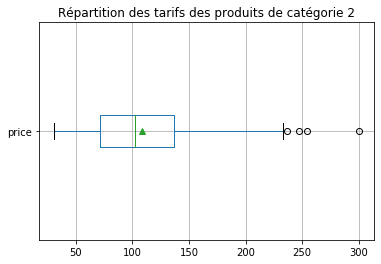

In [18]:
id_prod_cat2.boxplot(column='price', showmeans=True, vert=False)
plt.title('Répartition des tarifs des produits de catégorie 2')
plt.savefig("Répartition des tarifs des produits de catégorie 2.png")
plt.show()

In [19]:
id_prod_cat2.price.mean()

108.35468619246883

#### Identification des produits de catégorie 1

In [20]:
id_prod_cat1 = produits.loc[produits.categ == 1]
id_prod_cat1.sort_values(by='price', ascending=False).head()

,id_prod,price,categ
824,1_13,80.99,1
879,1_679,79.99,1
808,1_10,78.83,1
2827,1_171,73.99,1
2962,1_608,72.75,1


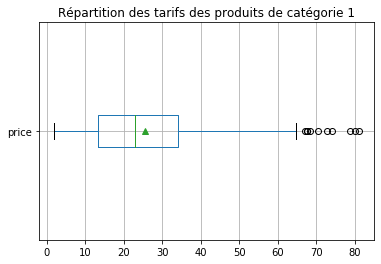

In [21]:
id_prod_cat1.boxplot(column='price', showmeans=True, vert=False)
plt.title('Répartition des tarifs des produits de catégorie 1')
plt.savefig("Répartition des tarifs des produits de catégorie 1.png")
plt.show()

In [22]:
id_prod_cat1.price.mean()

25.531420838971624

#### Identification des produits de catégorie 0

In [23]:
id_prod_cat0 = produits.loc[produits.categ == 0]
id_prod_cat0.sort_values(by='price', ascending=False).head()

,id_prod,price,categ
47,0_1629,40.99,0
2809,0_2147,39.99,0
1360,0_494,39.58,0
569,0_197,37.99,0
391,0_1239,37.99,0


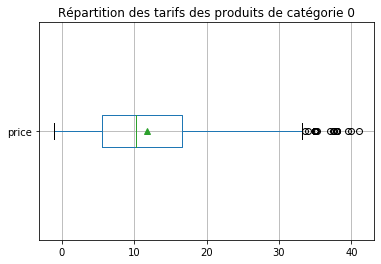

In [24]:
id_prod_cat0.boxplot(column='price', showmeans=True, vert=False)
plt.title('Répartition des tarifs des produits de catégorie 0')
plt.savefig("Répartition des tarifs des produits de catégorie 0.png")
plt.show()

In [25]:
id_prod_cat0.price.mean()

11.72728020788248

On constate une hiérarchisation des prix à travers la répartition des catégories suivantes:
- Les produits de catégorie 2 ont un 'id_prod' débutant par '2_' et un tarif compris entre 30,99 et 300 pour une moyenne de 108,35
- Les produits de catégorie 1 ont un id_prod débutant par '1_' et un tarif compris entre 2 et 80,99 pour une moyenne de 25,53
- Les produits de catégorie 0 ont un id_prod débutant par '0_' et ont un tarif compris entre -1 et 40,99 pour une moyenne de 11,72

Malgré cette tendance, les intervalles de prix se chevauchent à leurs extrémités. Il est donc difficile de déduire avec certitude la catégorie d'un produit selon son tarif.

#### Analyse de la corrélation entre 'id_prod' et 'categ':

In [26]:
produits.loc[produits.id_prod.str[0] != produits.categ.astype(str)]

,id_prod,price,categ
731,T_0,-1.0,0


#### Seul le produit dont l'identifiant est 'T_0' n'a pas sa 1e lettre pour catégorie d'appartenance. Ce produit est également le seul ayant un prix négatif.

## 2. Jointure extérieure des tables <a class='anchor' id='jointure'></a>

In [27]:
ventes_clients = pd.merge(ventes, clients, how='outer')
ventes_clients.head()

,id_prod,date,session_id,client_id,sex,birth
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977
1,1_596,2021-09-12 02:11:24.774608,s_88567,c_4450,f,1977
2,1_278,2021-09-10 15:09:01.555889,s_87835,c_4450,f,1977
3,0_1447,2021-05-25 00:17:56.841054,s_39094,c_4450,f,1977
4,0_1357,2021-08-01 10:43:25.039433,s_69919,c_4450,f,1977


In [28]:
data = pd.merge(ventes_clients, produits, how='outer')
data.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977.0,4.99,0.0
1,0_1483,2021-12-27 11:11:12.123067,s_140787,c_5433,f,1981.0,4.99,0.0
2,0_1483,2021-10-27 04:56:38.293970,s_110736,c_857,m,1985.0,4.99,0.0
3,0_1483,2021-07-04 06:43:45.676567,s_57626,c_3679,f,1989.0,4.99,0.0
4,0_1483,2021-09-19 08:45:43.735331,s_92165,c_1609,m,1980.0,4.99,0.0


## 3. Nettoyage des données <a class='anchor' id='nettoyage'></a>

#### 3.1. Analyse des produits dont le prix est négatif 

In [29]:
produits_prix_négatif = data.loc[data.price < 0]
produits_prix_négatif.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
335981,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,m,2001.0,-1.0,0.0
335982,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,m,2001.0,-1.0,0.0
335983,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,m,2001.0,-1.0,0.0
335984,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,m,2001.0,-1.0,0.0
335985,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1,m,2001.0,-1.0,0.0


In [30]:
produits_prix_négatif.client_id.unique()

array(['ct_1', 'ct_0'], dtype=object)

In [31]:
# Identification des acheteurs de produits dont le prix est négatif selon leur sexe
produits_prix_négatif.sex.value_counts()

f    106
m     94
Name: sex, dtype: int64

#### Identification du sexe des clients 'ct_0' et 'ct_1'

In [32]:
ct_0 = data.loc[data.client_id == 'ct_0']
ct_0.sex.unique()

array(['f'], dtype=object)

In [33]:
ct_1 = data.loc[data.client_id == 'ct_1']
ct_1.sex.unique()

array(['m'], dtype=object)

#### Dates d'achat des produits ayant un prix négatif

In [34]:
produits_prix_négatif.date.value_counts()

test_2021-03-01 02:30:02.237413    13
test_2021-03-01 02:30:02.237414     8
test_2021-03-01 02:30:02.237427     8
test_2021-03-01 02:30:02.237444     8
test_2021-03-01 02:30:02.237428     8
test_2021-03-01 02:30:02.237443     8
test_2021-03-01 02:30:02.237432     7
test_2021-03-01 02:30:02.237430     7
test_2021-03-01 02:30:02.237446     7
test_2021-03-01 02:30:02.237419     6
test_2021-03-01 02:30:02.237412     6
test_2021-03-01 02:30:02.237437     6
test_2021-03-01 02:30:02.237435     6
test_2021-03-01 02:30:02.237440     6
test_2021-03-01 02:30:02.237426     6
test_2021-03-01 02:30:02.237424     5
test_2021-03-01 02:30:02.237442     5
test_2021-03-01 02:30:02.237420     5
test_2021-03-01 02:30:02.237429     5
test_2021-03-01 02:30:02.237436     5
test_2021-03-01 02:30:02.237441     5
test_2021-03-01 02:30:02.237438     5
test_2021-03-01 02:30:02.237416     5
test_2021-03-01 02:30:02.237425     4
test_2021-03-01 02:30:02.237431     4
test_2021-03-01 02:30:02.237434     4
test_2021-03

Les achats de produits à prix négatifs ne sont espacés que de quelques millisecondes. On peut déduire de toutes les caractéristiques mises en évidence que les produits à prix négatifs ne nous renseignent pas sur l'activité

In [35]:
# Suppression des données relatives aux produits dont le prix est négatif
data.drop(produits_prix_négatif.index, inplace=True)

####  3.2. Les clients enregistrés n'ayant effectué aucun achat 

In [36]:
clients_inactifs = data.loc[data.id_prod.isnull()]
print("{} clients se sont enregistrés sans jamais réaliser d'achat.".format(len(clients_inactifs)))

21 clients se sont enregistrés sans jamais réaliser d'achat.


In [37]:
print('Les clients inactifs représentent {}% de la clientèle de la plateforme.'.format(round((len(clients_inactifs) / len(clients) * 100), 2)))

Les clients inactifs représentent 0.24% de la clientèle de la plateforme.


In [38]:
# Suppression des clients inactifs du DataFrame
data.drop(clients_inactifs.index, inplace=True)

#### 3.3. Analyse des produits n'ayant fait l'objet d'aucun achat

In [39]:
produits_délaissés = data.loc[data.client_id.isnull()]

In [40]:
len(produits_délaissés)

22

In [41]:
produits_délaissés.categ.value_counts()

0.0    17
2.0     3
1.0     2
Name: categ, dtype: int64

In [42]:
print('Les produits n\'ayant fait l\'objet d\'aucun achat représentent {}% du catalogue des produits mis en ligne.'.format(round((len(produits_délaissés) / len(produits) * 100), 2)))

Les produits n'ayant fait l'objet d'aucun achat représentent 0.67% du catalogue des produits mis en ligne.


In [43]:
#Suppression des produits n'ayant fait l'objet d'aucun achat du DataFrame
data.drop(produits_délaissés.index, inplace=True)

#### 3.4. Analyse des produits achetés dont le montant est inconnu

In [44]:
produit_sans_prix = data.loc[data.price.isnull()]
produit_sans_prix.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
32299,0_2245,2021-04-10 06:15:32.619826,s_18510,c_277,f,2000.0,NaN,NaN
32300,0_2245,2021-12-10 21:31:18.303110,s_132471,c_3519,m,1974.0,NaN,NaN
32301,0_2245,2021-04-10 09:22:57.768041,s_18566,c_8240,f,1978.0,NaN,NaN
32302,0_2245,2021-10-04 21:20:27.540982,s_100047,c_8138,f,1984.0,NaN,NaN
32303,0_2245,2021-03-28 21:39:14.337424,s_12792,c_2688,f,1968.0,NaN,NaN


In [45]:
produit_sans_prix.id_prod.value_counts()

0_2245    103
Name: id_prod, dtype: int64

Le produit dont l'id est 0_2245 a fait l'objet de 103 achats non répertoriés. Malgré cette absence d'information, nous remarquons que son nom confirme son appartenance à la catégorie 0 dont les produits ont un prix moyen de 11,72. 

#### Imputation des produits dont le montant est inconnu par les valeurs moyennes de leur catégorie d'appartenance:

In [46]:
data.price.loc[data.categ.isnull()] = float(11.72)
data.categ.loc[data.categ.isnull()] = float(0.0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 337015
Data columns (total 8 columns):
id_prod       336816 non-null object
date          336816 non-null object
session_id    336816 non-null object
client_id     336816 non-null object
sex           336816 non-null object
birth         336816 non-null float64
price         336816 non-null float64
categ         336816 non-null float64
dtypes: float64(3), object(5)
memory usage: 23.1+ MB


C:\Users\Thibaut\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### 3.5. Conversion des données au format adapté <a class='anchor' id='conversion'></a>

In [47]:
data.birth = data.birth.astype(int)
data.categ = data.categ.astype(int)
data.categ = data.categ.apply(str)
data.date = data.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 337015
Data columns (total 8 columns):
id_prod       336816 non-null object
date          336816 non-null datetime64[ns]
session_id    336816 non-null object
client_id     336816 non-null object
sex           336816 non-null object
birth         336816 non-null int32
price         336816 non-null float64
categ         336816 non-null object
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 21.8+ MB


## 4. Analyse des données <a class='anchor' id='analyse'></a>

### 4.1 Mise en évidence des données relatives à l'âge des clients et à la date d'achat <a class='anchor' id='date_achat'></a>

#### Détermination de l'âge des clients au moment de l'achat et à la date actuelle:

In [48]:
# Ajout de colonnes intégrant des données d'ordre temporel
data['purchase_year'] = pd.DatetimeIndex(data['date']).year
data['month_range'] = pd.DatetimeIndex(data['date']).map(lambda x: x.strftime('%Y-%m'))
data['buyer_age'] = data['purchase_year'] - data['birth']
data['client_age'] = 2022 - data['birth']
data['week_day'] = data.date.apply(lambda x: x.weekday())

#### Volums d'achats selon le jour de la semaine

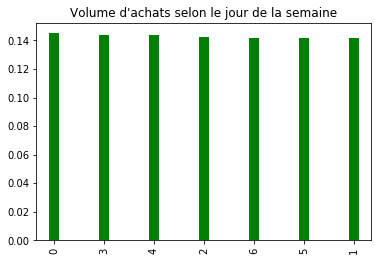

In [49]:
# Graphique en barres
data.week_day.value_counts(normalize=True).plot(kind='bar',color='green', width=0.2)
plt.title('Volume d\'achats selon le jour de la semaine')
plt.show()

Nous constatons une certaine homogénéité du chiffre d'affaires d'un jour à l'autre.

In [50]:
# Changement de nom des jours de la semaine
data.week_day.loc[data.week_day == 0] = '1_Lundi'
data.week_day.loc[data.week_day == 1] = '2_Mardi'
data.week_day.loc[data.week_day == 2] = '3_Mercredi'
data.week_day.loc[data.week_day == 3] = '4_Jeudi'
data.week_day.loc[data.week_day == 4] = '5_Vendredi'
data.week_day.loc[data.week_day == 5] = '6_Samedi'
data.week_day.loc[data.week_day == 6] = '7_Dimanche'

In [51]:
# Chiffre d'affaires réalisé selon le jour de la semaine et en ordre décroissant
income_per_week_day = data.groupby('week_day').sum()
income_per_week_day[['price']].sort_values(by='price', ascending=False)

,price
week_day,
1_Lundi,843030.06
5_Vendredi,838217.87
4_Jeudi,830724.33
2_Mardi,825179.12
7_Dimanche,821374.51
6_Samedi,820970.36
3_Mercredi,818288.68


Les variations d'un jour à l'autre de la semaine sont donc assez faibles

#### Analyse des résultats selon le mois de l'année

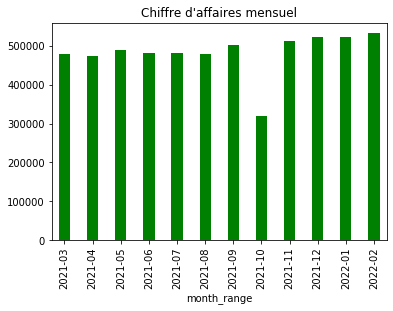

In [52]:
# Représentation des chiffres mensuels
amount_per_month = data.groupby('month_range').sum()
amount_per_month.price.sort_index().plot(kind='bar', color='green', width=0.4)
plt.title('Chiffre d\'affaires mensuel')
plt.show()

In [53]:
# Résultat des ventes par mois en ordre décroissant
income_per_month = data.groupby('month_range').sum()
income_per_month[['price']].sort_values(by='price', ascending=False)

,price
month_range,
2022-02,532869.80
2021-12,523019.72
2022-01,523013.91
2021-11,513007.37
2021-09,502911.92
2021-05,489461.71
2021-06,481339.98
2021-07,480945.54
2021-03,479417.51


Le graphique montre une relative homogénéité des résultats mensuels, avec cependant une exception: le mois d'octobre qui accuse une très nette baisse de l'activité. Cette singularité invite à une analyse plus fine des ventes réalisées ce mois-ci.

#### Analyse du mois d'Octobre 2021

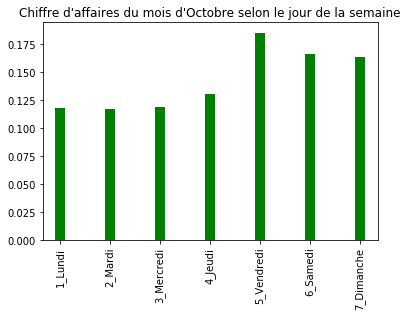

In [54]:
# Répartition du chiffre d'affaires d'Octobre selon le jour de la semaine
data_oct = data.loc[data.month_range == '2021-10']
data_oct.week_day.value_counts(normalize=True).sort_index().plot(kind='bar', color='green', width=0.2)
plt.title('Chiffre d\'affaires du mois d\'Octobre selon le jour de la semaine')
plt.show()

In [55]:
# Ajout d'une colonne spécifiant le jour du mois où les achats ont été effectués
data_oct['month_day'] = pd.DatetimeIndex(data_oct['date']).map(lambda x: x.strftime('%d'))
data_oct['month_day'] = data_oct['month_day'].astype(int)

C:\Users\Thibaut\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Thibaut\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


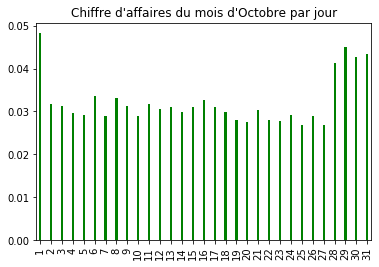

In [56]:
# Répartition du chiffre d'affaires d'Octobre selon le jour du mois
data_oct.month_day.value_counts(normalize=True).sort_index().plot(kind='bar',color='green', width=0.2)
plt.title('Chiffre d\'affaires du mois d\'Octobre par jour')
plt.show()

Le dernier graphique montre un net ralentissement de l'activité du 2 au 27 Octobre 2021.

In [57]:
# Restriction de notre analyse à la période du 2 au 27 Octobre
data_oct = data_oct.loc[(data_oct.month_day>=2) & (data_oct.month_day<=27)]

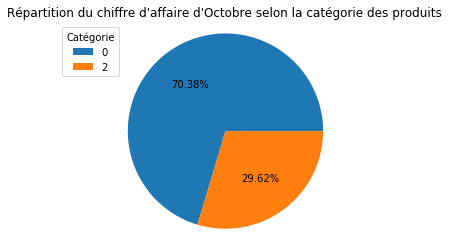

In [58]:
# Répartition du chiffre d'affaires d'Octobre (du 2 au 27) selon la catégorie des produits vendus
achats_oct_categorie = data_oct.groupby('categ').sum()
plt.pie(achats_oct_categorie.price, autopct='%.2f%%')
plt.axis('equal')
plt.title('Répartition du chiffre d\'affaire d\'Octobre selon la catégorie des produits')
plt.legend([0,2], title='Catégorie', loc='upper left', fontsize=10)
plt.show()

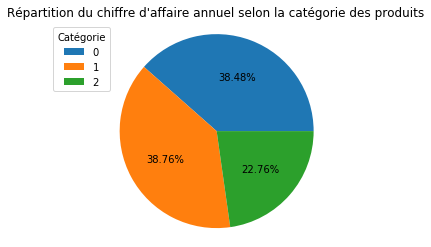

In [59]:
# Comparaison avec la répartition du chiffre d'affaires annuel par catégorie
nb_achats_categorie = data.groupby('categ').sum()
plt.pie(nb_achats_categorie.price, autopct='%.2f%%')
plt.legend([0,1,2], title='Catégorie', loc='upper left', fontsize=10)
plt.axis('equal')
plt.title('Répartition du chiffre d\'affaire annuel selon la catégorie des produits')
plt.show()

L'analyse des ventes par catégorie montre une nette sur-représentation des produits de catégorie 0 dans les ventes du 2 au 27 octobre. A l'inverse, les produits de catégorie 1 n'ont fait l'objet d'aucun achat

In [60]:
# Part des biens vendus en Octobre dans le catalogue annuel
print('{}% des produits du catalogue ont été vendus entre le 2 et le 27 Octobre'.format(round(len(data_oct.groupby('id_prod').count())/len(produits)*100, 2)))

55.37% des produits du catalogue ont été vendus entre le 2 et le 27 Octobre


In [61]:
# Pourcentage des produits de catégorie 0 vendus dans le catalogue annuel
part_oct_ocat0 = len(data_oct.loc[data_oct.categ == "0"].groupby('id_prod').count())/len(produits.loc[produits.categ == 0].groupby('id_prod').count())*100
print('{}% des produits du catalogue de catégorie 0 ont été vendus entre le 2 et le 27 Octobre'.format(round(part_oct_ocat0, 2)))

72.54% des produits du catalogue de catégorie 0 ont été vendus entre le 2 et le 27 Octobre


In [62]:
# Pourcentage des produits de catégorie 1 disponibles dans le catalogue annuel
part_oct_ocat1 = len(data_oct.loc[data_oct.categ == "1"].groupby('id_prod').count())/len(produits.loc[produits.categ == 1].groupby('id_prod').count())*100
print('{}% des produits du catalogue de catégorie 1 ont été vendus entre le 2 et le 27 Octobre'.format(round(part_oct_ocat1, 2)))

0.0% des produits du catalogue de catégorie 1 ont été vendus entre le 2 et le 27 Octobre


In [63]:
# Pourcentage des produits de catégorie 2 disponibles dans le catalogue annuel
part_oct_ocat2 = len(data_oct.loc[data_oct.categ == "2"].groupby('id_prod').count())/len(produits.loc[produits.categ == 2].groupby('id_prod').count())*100
print('{}% des produits du catalogue de catégorie 2 ont été vendus entre le 2 et le 27 Octobre'.format(round(part_oct_ocat2, 2)))

60.67% des produits du catalogue de catégorie 2 ont été vendus entre le 2 et le 27 Octobre


55% de la diversité des produits du catalogue annuel ont été vendus entre le 2 et le 27 Octobre. Plus précisément, 72.5% des produits de catégorie 0 et 60.6% des produits de catégorie 2 ont fait l'objet d'un achat à cette période, tandis qu'aucun produit de catégorie 1 n'a été vendu. Cette observation suggère que la baisse de l'activité s'explique soit par une rupture des stocks des produits de catégorie 1 soit par leur disparition du système informatique entre le 2 et le 27 Octobre.

### 4.2 Montants dépensés à chaque session <a class='anchor' id='montants_paniers'></a>

#### Répartition du montant des paniers

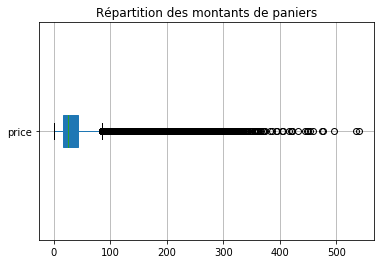

In [64]:
data_sessions = data.groupby('session_id').sum()
data_sessions.boxplot(column='price', vert=False, patch_artist=True)
plt.title('Répartition des montants de paniers')
plt.savefig("Répartition des montants de paniers.png")
plt.show()

In [65]:
data_sessions.price.mean()

34.26708352546178

Le graphique montre une forte dispersion des paniers de dépense.

#### Représentation graphique excluant les outliers :

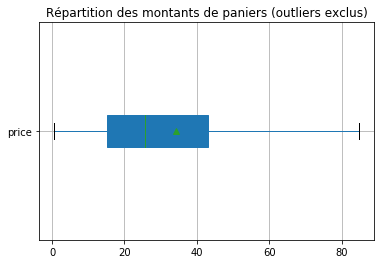

In [66]:
data_sessions.boxplot(column='price', vert=False, showmeans=True, showfliers=False, patch_artist=True)
plt.title('Répartition des montants de paniers (outliers exclus)')
plt.show()

#### Valeurs des paniers classés en ordre décroissant

In [67]:
data_sessions[['price']].sort_values(by='price', ascending=False).head()

,price
session_id,
s_123227,539.23
s_83158,535.17
s_150439,496.22
s_170478,476.19
s_165683,473.98


#### Moyenne du panier de chaque session conclue par un achat:

In [68]:
print('Le panier moyen s\'élève à {}'.format(round(data_sessions.price.mean(), 2)))

Le panier moyen s'élève à 34.27


### 4.3 Montants dépensés par les clients <a class='anchor' id='montants_clients'></a>

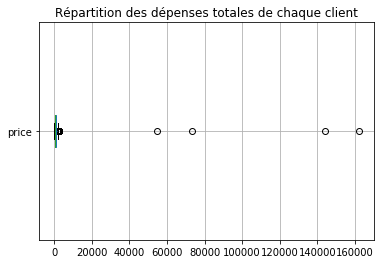

In [69]:
data_clients = data.groupby('client_id').sum()
data_clients.boxplot(column='price', vert=False, patch_artist=True)
plt.title('Répartition des dépenses totales de chaque client')
plt.savefig('Répartition des dépenses totales de chaque client.png')
plt.show()

4 clients se détachent par la valeur totale de leurs achats.

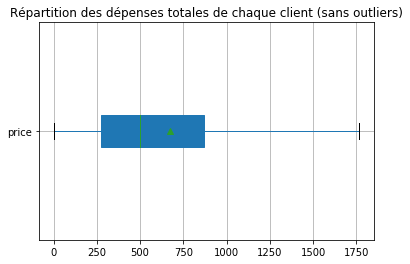

In [70]:
data_clients = data.groupby('client_id').sum()
data_clients.boxplot(column='price', showmeans=True, showfliers=False, vert=False, patch_artist=True)
plt.title('Répartition des dépenses totales de chaque client (sans outliers)')
plt.savefig('Répartition des dépenses totales de chaque client (sans outliers).png')
plt.show()

In [71]:
# Identification de ces 4 clients
data_clients[['price']].sort_values(by='price', ascending=False).head()

,price
client_id,
c_1609,162007.34
c_4958,144257.21
c_6714,73220.78
c_3454,54466.36
c_7959,2564.25


Le volume d'achat de ces 4 clients se détache très nettement de celui des autres clients. Afin de mieux saisir la nature de ce petit groupe de clients, nous allons analyser leurs achats de manière un peu plus approfondie.

#### Restriction des données relatives aux 4 principaux clients de la boutique

In [72]:
data_pro = data.loc[(data.client_id == 'c_1609') | (data.client_id == 'c_4958') | (data.client_id == 'c_6714') | (data.client_id == 'c_3454')]

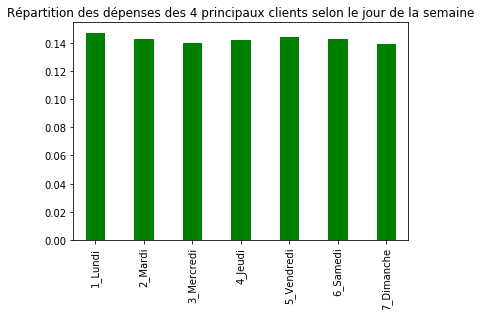

In [73]:
# Identification des jours de semaine selon le nombre d'achats comptabilisés
data_pro.week_day.value_counts(normalize=True).sort_index().plot(kind='bar', color='green', width=0.4)
plt.title('Répartition des dépenses des 4 principaux clients selon le jour de la semaine')
plt.show()

La répartition des achats est relativement homogène. Le Dimanche semble avoir accueilli à peu près autant d'achats que les autres jours.

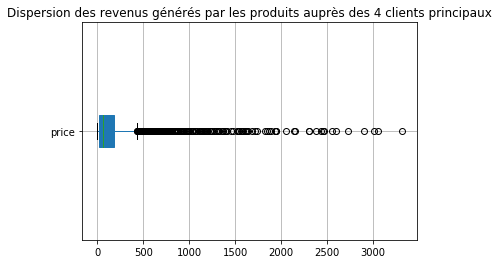

In [74]:
# Calcul du chiffre d'affaires réalisé par chaque produit auprès des 4 principaux clients
ca_prod_pro = data_pro.groupby('id_prod').sum()
ca_prod_pro.boxplot(column='price', vert=False, patch_artist=True)
plt.title('Dispersion des revenus générés par les produits auprès des 4 clients principaux')
plt.show()

In [75]:
# Classement des produits selon leur chiffre d'affaires généré auprès des 4 plus gros clients.
ca_prod_pro[['price']].sort_values(by='price', ascending=False).head()

,price
id_prod,
2_112,3310.93
2_110,3050.25
2_209,3009.57
2_135,2897.58
2_102,2720.44


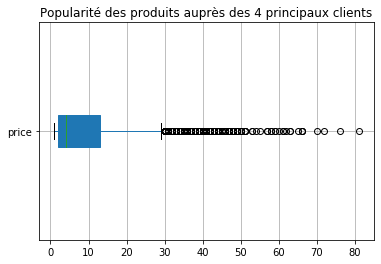

In [76]:
# Popularité des produits auprès des 4 principaux clients
nb_prod_pro = data_pro.groupby('id_prod').count()
nb_prod_pro.boxplot(column='price', vert=False, patch_artist=True)
plt.title('Popularité des produits auprès des 4 principaux clients')
plt.show()

In [77]:
nb_prod_pro[['price']].sort_values(by='price', ascending=False).head()

,price
id_prod,
1_498,81
1_403,76
1_425,72
1_400,70
1_417,66


In [78]:
# Focus sur le produit le plus vendu à ces clients (id: 1_498)
prod_1_498 = data.loc[data.id_prod == '1_498']
prod_1_498.groupby('client_id').count().sort_values(by='session_id', ascending=False)[['session_id']]

,session_id
client_id,
c_1609,26
c_6714,24
c_3454,20
c_4958,11
c_6726,3
...,...
c_3775,1
c_3782,1
c_3786,1


Les 4 principaux clients de ce produit sont les 4 clients que nous avons identifiés.

In [79]:
data_pro.id_prod.count()

23165

In [80]:
nb_prod_pro.session_id.mean()

9.84487887802805

A eux quatre, les clients professionnels ont acheté 23 165 articles, soit en moyenne près de 10 de chacun des articles du catalogue.

Nous pouvons déduire de ces résultats que les commandes faites par ces clients se réalisent dans de tels volumes qu'elles sont vraisemblablement d'ordre professionnel. 

Il n'est donc plus nécessaire de considérer ces clients comme des individus mais plutôt comme des entités. Dans le DataFrame 'data', nous allons donc permettre leur identification en changeant leur sexe et leur âge de la manière suivante:

In [81]:
# Identification des clients dits professionnels en renommant leur sexe par 'pro' et leur âge par NaN
data.sex.loc[(data.client_id == 'c_1609') | (data.client_id == 'c_4958') | (data.client_id == 'c_6714') | (data.client_id == 'c_3454')] = str('pro')
data.buyer_age.loc[(data.client_id == 'c_1609') | (data.client_id == 'c_4958') | (data.client_id == 'c_6714') | (data.client_id == 'c_3454')] = np.nan
data.client_age.loc[(data.client_id == 'c_1609') | (data.client_id == 'c_4958') | (data.client_id == 'c_6714') | (data.client_id == 'c_3454')] = np.nan
data_pro = data.loc[(data.client_id == 'c_1609') | (data.client_id == 'c_4958') | (data.client_id == 'c_6714') | (data.client_id == 'c_3454')]

C:\Users\Thibaut\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


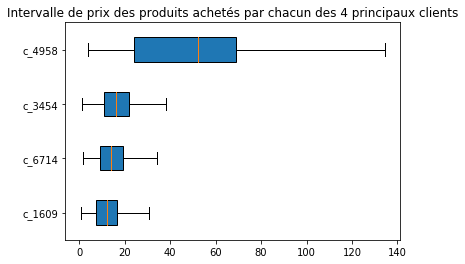

In [82]:
# Répartition des montants des produits achetés par les clients professionnels

clients_pro = data_pro.client_id.unique()
groupes = []
for m in clients_pro:
    groupes.append(data[data.client_id==m]['price'])

plt.boxplot(groupes, labels = clients_pro, showfliers=False, vert=False, patch_artist=True)
plt.title('Intervalle de prix des produits achetés par chacun des 4 principaux clients')
plt.show()

In [83]:
# Création d'une table pivot représentant les montants de chaque panier payé par les clients professionnels
data_pro_session = data_pro.pivot_table('price', 'session_id', 'client_id', aggfunc=sum)

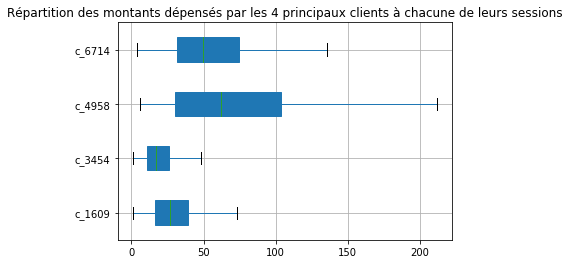

In [84]:
data_pro_session.boxplot(showfliers=False, vert=False, patch_artist=True)
plt.title('Répartition des montants dépensés par les 4 principaux clients à chacune de leurs sessions')
plt.show()

In [85]:
# Réalisation d'une table pivot énumérant la quantité de produits achetés par les clients professionnels 

X = "id_prod"
Y = "client_id"
cont = data_pro[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont.sort_values(by='Total', ascending=False).head()

client_id,c_1609,c_3454,c_4958,c_6714,Total
id_prod,,,,,
Total,12855.0,3275.0,2562.0,4473.0,23165
1_498,26.0,20.0,11.0,24.0,81
1_403,17.0,30.0,10.0,19.0,76
1_425,23.0,22.0,9.0,18.0,72
1_400,29.0,12.0,12.0,17.0,70


Le client c_1609 a commandé 12 855 produits, le client c_3454 a commandé 3 275  produits, le client c_4958 a commandé 2 562 produits, enfin le client c_6714 a commandé 4 473 produits.

#### Représentation graphique des dépenses totales de chaque client particulier

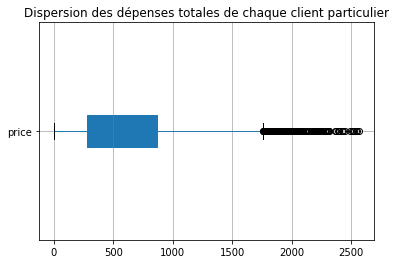

In [86]:
data_particuliers = data.loc[(data.sex == 'm') | (data.sex == 'f')]
data_clients_particuliers = data_particuliers.groupby('client_id').sum()
data_clients_particuliers.boxplot(column='price', vert=False, patch_artist=True)
plt.title('Dispersion des dépenses totales de chaque client particulier')
plt.show()

#### Moyenne des dépenses de chaque client

In [87]:
data_clients.price.mean()

674.1610383720915

In [88]:
data_clients_particuliers.price.mean()

623.9917682643083

En retirant les 4 plus gros acheteurs du compte des 8 600 clients de la boutique, le montant moyen dépensé par client passe de 674 à 624

### 4.4 Volume des achats <a class='anchor' id='volume_achats'></a>

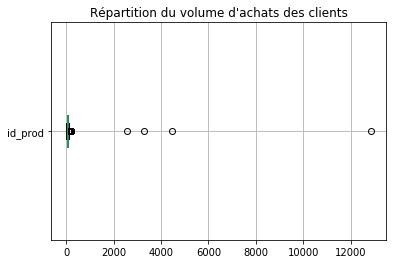

In [89]:
nb_achats_clients = data.groupby('client_id')[['id_prod']].count()
nb_achats_clients.boxplot(column='id_prod', vert=False)
plt.title('Répartition du volume d\'achats des clients')
plt.show()

In [90]:
nb_achats_clients.sort_values('id_prod', ascending=False).head()

,id_prod
client_id,
c_1609,12855
c_6714,4473
c_3454,3275
c_4958,2562
c_2140,195


Ici aussi, 4 clients se détachent par le nombre d'achats réalisés. Sans surprise, il s'agit des clients que nous avons précédemment identifiés comme professionnels, ainsi que le montre la restriction suivante:

In [91]:
data_pro.groupby('client_id')[['price']].count()

,price
client_id,
c_1609,12855
c_3454,3275
c_4958,2562
c_6714,4473


#### Restriction des données aux particuliers

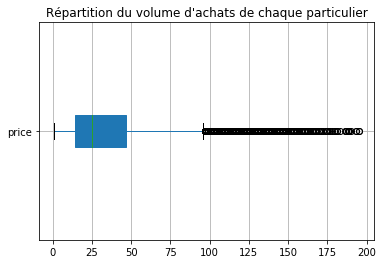

In [92]:
nb_achats_particuliers = data_particuliers.groupby('client_id').count()
nb_achats_particuliers.boxplot(column='price', vert=False, patch_artist=True)
plt.title('Répartition du volume d\'achats de chaque particulier')
plt.show()

In [93]:
data.groupby('client_id')[['price']].count().mean()

price    39.164651
dtype: float64

In [94]:
data_pro.groupby('client_id')[['price']].count().mean()

price    5791.25
dtype: float64

Les particuliers ont réalisé en moyenne 39 achats, tandis que les clients dits "professionnels" ont réalisé une moyenne de 5 791 achats.

### 4.5 Les produits et leur popularité <a class='anchor' id='popularité_produits'></a>

#### Selon le chiffre d'affaires qu'ils génèrent

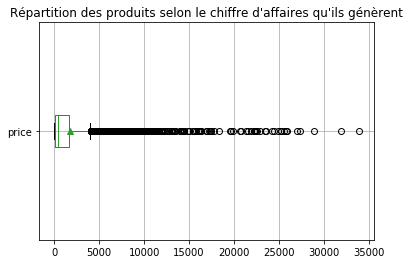

In [95]:
ventes_produits = data.groupby('id_prod').sum()
ventes_produits.boxplot('price', showmeans=True, vert=False)
plt.title('Répartition des produits selon le chiffre d\'affaires qu\'ils génèrent')
plt.show()

In [96]:
ventes_produits[['price']].sort_values('price', ascending=False).head()

,price
id_prod,
2_135,33874.09
2_112,31960.61
2_102,28919.46
2_209,27296.10
2_110,27016.50


On constate que les 5 produits générant le plus de chiffres sont tous de catégorie 2.

In [97]:
ventes_produits.price.mean()

1775.7381102603395

In [98]:
ventes_produits.price.median()

402.29999999999995

Le chiffre d'affaires moyen des produits du catalogue est de 1 775. La valeur médiane des revenus des produits est de 402. Enfin, le produit le plus populaire a généré un revenu de 33 874.

#### Selon leur fréquence de vente

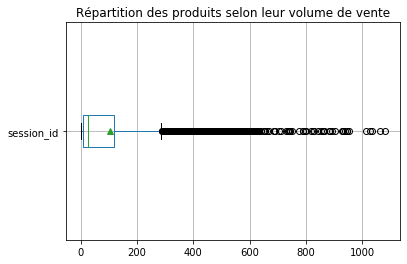

In [99]:
nb_achats_produits = data.groupby('id_prod').count()
nb_achats_produits.boxplot(column='session_id', showmeans=True, vert=False)
plt.title('Répartition des produits selon leur volume de vente')
plt.show()

In [100]:
nb_achats_produits[['session_id']].sort_values(by='session_id', ascending=False)

,session_id
id_prod,
1_369,1081
1_417,1062
1_498,1036
1_414,1027
1_425,1013
...,...
0_94,1
0_1683,1
0_1544,1


Les produits les plus populaires sont tous de catégorie 1, tandis que les produits les moins populaires sont plutôt de catégorie 0 (à note qu'un précédent résultat avait montré que sur les 20 produits n'ayant fait l'objet d'aucun achat, 17 d'entre eux sont également de catégorie 0)

In [101]:
# Part des produits du catalogue ayant fait l'objet de 4 achats maximum
len(nb_achats_produits.loc[nb_achats_produits.session_id < 5]) / len(nb_achats_produits) * 100


12.741194486983154

In [102]:
# Nombre moyen d'achats par produits
nb_achats_produits.session_id.mean()

103.15957120980092

In [103]:
# Nombre médian d'achats par produits
nb_achats_produits.session_id.median()

28.0

Les produits du catalogue ont été achetés en moyenne à 103 reprises. La valeur médiane du nombre d'achats de l'ensemble des produits est quant à elle de 28. Enfin, le produit le plus populaire a fait l'objet de 1 081 achats. 

#### Selon leur catégorie

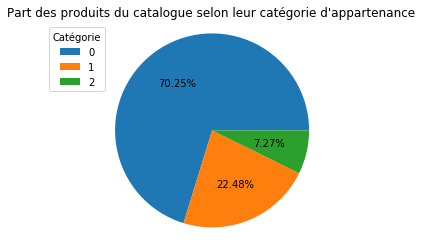

In [104]:
# Répartition des produits selon leur catégorie
plt.pie(produits.categ.value_counts(), autopct='%.2f%%')
plt.legend([0,1,2], title='Catégorie', loc='upper left', fontsize=10)
plt.axis('equal')
plt.title('Part des produits du catalogue selon leur catégorie d\'appartenance')
plt.savefig("Part des produits du catalogue selon leur catégorie d\'appartenance.png")
plt.show()

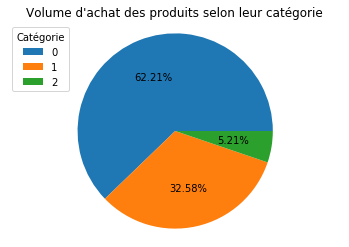

In [105]:
# Répartition du volume des achats selon la catégorie des produits
plt.pie(data.categ.value_counts(), autopct='%.2f%%')
plt.legend([0,1,2], title='Catégorie', loc='upper left', fontsize=10)
plt.axis('equal')
plt.title('Volume d\'achat des produits selon leur catégorie')
plt.savefig("Volume d\'achat des produits selon leur catégorie.png")
plt.show()

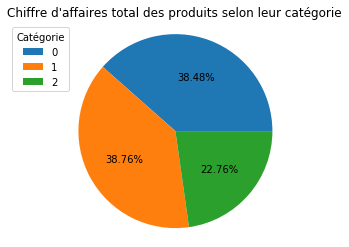

In [106]:
# Répartition du chiffre d'affaires selon la catégorie des produits
nb_achats_categorie = data.groupby('categ').sum()
plt.pie(nb_achats_categorie.price, autopct='%.2f%%')
plt.axis('equal')
plt.title('Chiffre d\'affaires total des produits selon leur catégorie')
plt.legend([0,1,2], title='Catégorie', loc='upper left', fontsize=10)
plt.savefig("Chiffre d\'affaires total des produits selon leur catégorie.png")
plt.show()

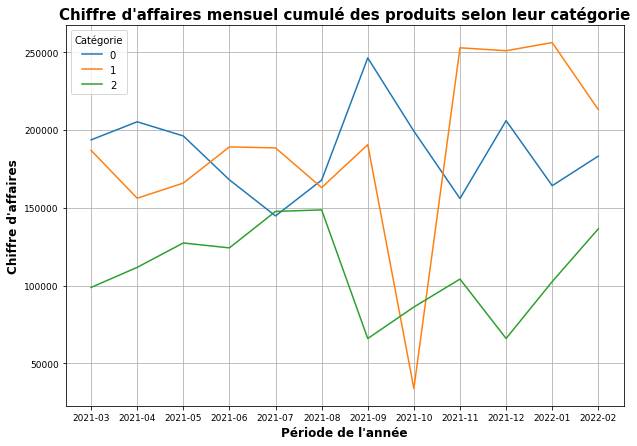

In [107]:
# Réalisation d'une table pivot énumérant le chiffre d'affaires cumulé des produits par catégorie et par mois
CA_cat_mois = data.pivot_table('price', 'month_range', 'categ', aggfunc=sum)


# Aspect du graphique
plt.figure(figsize=(10,7))
plt.plot(CA_cat_mois)
plt.xlabel('Période de l\'année', fontsize=12, fontweight='bold')
plt.ylabel('Chiffre d\'affaires', fontsize=12, fontweight='bold')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend([0, 1, 2], title='Catégorie', loc='upper left', fontsize=10)
plt.grid(True)
plt.title('Chiffre d\'affaires mensuel cumulé des produits selon leur catégorie', fontsize=15, fontweight='bold')
plt.savefig('Chiffre d\'affaires mensuel cumulé des produits selon leur catégorie.png')
plt.show()

Le graphique montre une nette diminution de la consommation des produits de catégorie 1 en Octobre 2021.
Les courbes indiquent aussi une corrélation négative entre les produits de catégorie 0 et les produits de catégorie 2 puisque la baisse de l'un entraîne généralement une hausse de l'autre. Après Octobre 2021 néanmoins, il semble que les produits de catégorie 1 ont vu la diminution de leurs ventes être nettement compensée.

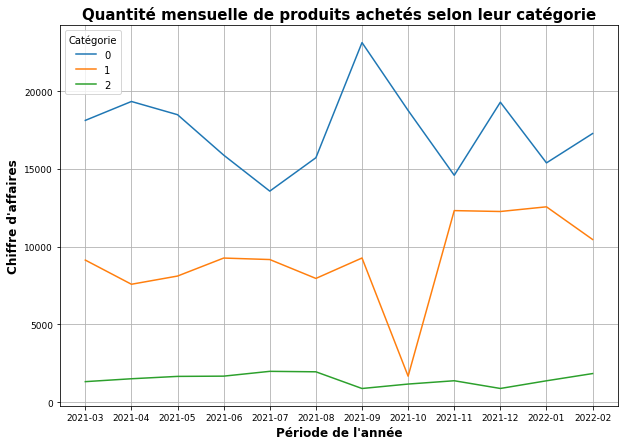

In [108]:
# Réalisation d'une table pivot énumérant le nombre de produits achetés par catégorie et par mois
NB_cat_mois = data.pivot_table('price', 'month_range', 'categ', aggfunc=len)


# Aspect du graphique
plt.figure(figsize=(10,7))
plt.plot(NB_cat_mois)
plt.xlabel('Période de l\'année', fontsize=12, fontweight='bold')
plt.ylabel('Chiffre d\'affaires', fontsize=12, fontweight='bold')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend([0, 1, 2], title='Catégorie', loc='upper left', fontsize=10)
plt.grid(True)
plt.title('Quantité mensuelle de produits achetés selon leur catégorie', fontsize=15, fontweight='bold')
plt.show()

Lorsqu'on analyse les quantités de produits achetées, les corrélations sont moins évidentes à identifier. Les produits de catégorie 0 sont nettement sur-représentés, à l'inverse des produits de catégorie 2.

### 4.6 Mesures de concentration <a class='anchor' id='mesures_concentration'></a>

#### Cumul croissant de la part du chiffre d'affaires généré par les produits du catalogue (courbe de Lorenz)

In [109]:
# Classement des produits selon le chiffre d'affaires qu'ils ont généré
ca_prod = data.groupby('id_prod').sum()
ca_prod[['price']].sort_values(by='price', ascending=False).head()

,price
id_prod,
2_135,33874.09
2_112,31960.61
2_102,28919.46
2_209,27296.10
2_110,27016.50


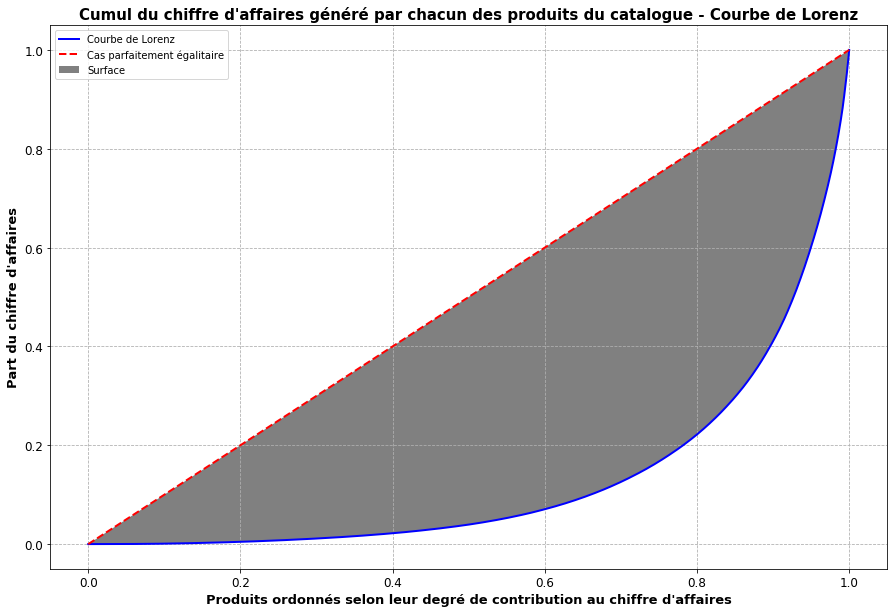

In [156]:
# Configuration des valeurs
vente = ca_prod['price'].values
n = len(vente)
lorenz = np.cumsum(np.sort(vente)) / vente.sum()
lorenz = np.append([0],lorenz)
xaxis = np.linspace(0,1,len(lorenz)) 

# Configuration du graphique
plt.figure(figsize = (15,10)) # Taille du graphique
plt.plot(xaxis,lorenz,'b',linestyle='-',linewidth=2,label='Courbe de Lorenz') # Courbe bleue
plt.plot([0,1],[0,1], 'r',linestyle='--', linewidth=2, label='Cas parfaitement égalitaire') # Courbe rouge
plt.fill_between(xaxis, xaxis, lorenz,facecolor='grey', label='Surface') # Remplissage de l'aire qui sépare les courbes
plt.xlabel('Pourcentage de produits vendus',fontsize=10,fontweight = 'bold') # Label de l'abscisse
plt.ylabel('Pourcentage du CA du site', fontsize=10,fontweight='bold') # Label de l'ordonnée
plt.xticks(fontsize=12) # taille des repères numériques
plt.yticks(fontsize=12)
plt.xlabel('Produits ordonnés selon leur degré de contribution au chiffre d\'affaires', fontsize=13, fontweight='bold')
plt.ylabel('Part du chiffre d\'affaires', fontsize=13, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True,linestyle='--') # Configuration de la grille de repère
plt.title('Cumul du chiffre d\'affaires généré par chacun des produits du catalogue - Courbe de Lorenz', fontsize=15, fontweight='bold')
plt.savefig('Cumul du chiffre d\'affaires généré par chacun des produits du catalogue - Courbe de Lorenz.png')
plt.show()

La moitié la moins populaire des produits du catalogue représentent moins de 10% du chiffre d'affaires. En théorie, le catalogue pourrait être réduit de moitié et n'entraîner qu'une baisse du chiffre d'affaire de 10%.

In [111]:
AUC_produits = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2)/n
S = 0.5 - AUC_produits
gini_produits = 2*S
print('Le coefficient de Gini s\'élève à {:0.3f}.'.format(gini_produits))
print('Il révèle une forte inégalité de rendement économique parmi les produits du catalogue.')

Le coefficient de Gini s'élève à 0.738.
Il révèle une forte inégalité de rendement économique parmi les produits du catalogue.


#### Mesure de concentration des clients de la boutique selon le chiffre d'affaires qu'ils rapportent (courbe de Lorenz)

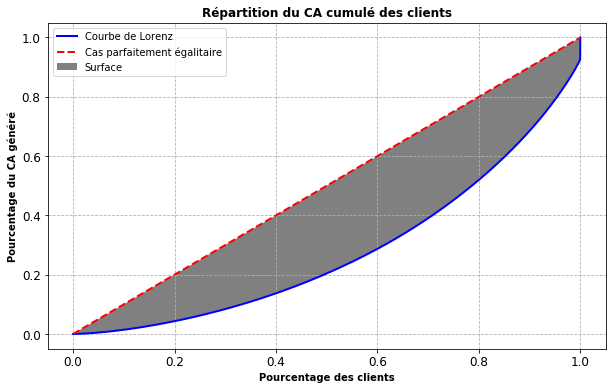

In [112]:
# Aggrégation des données par clients
ca_clients = data.groupby('client_id').sum()

# Configuration des valeurs
vente = ca_clients['price'].values
n = len(vente)
lorenz = np.cumsum(np.sort(vente)) / vente.sum()
lorenz = np.append([0],lorenz)
xaxis = np.linspace(0,1,len(lorenz)) 

# Configuration du graphique
plt.figure(figsize = (10,6)) # Taille du graphique
plt.plot(xaxis,lorenz,'b',linestyle='-',linewidth=2,label='Courbe de Lorenz') # Courbe bleue
plt.plot([0,1],[0,1], 'r',linestyle='--', linewidth=2, label='Cas parfaitement égalitaire') # Courbe rouge
plt.fill_between(xaxis, xaxis, lorenz,facecolor='grey', label='Surface') # Remplissage de l'aire qui sépare les courbes
plt.xlabel('Pourcentage des clients',fontsize=10,fontweight = 'bold') # Label de l'abscisse
plt.ylabel('Pourcentage du CA généré', fontsize=10,fontweight='bold') # Label de l'ordonnée
plt.xticks(fontsize=12) # taille des repères numériques
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True,linestyle='--') # Configuration de la grille de repère
plt.title('Répartition du CA cumulé des clients', fontweight='bold')
plt.savefig("Répartition du CA cumulé des clients.png")
plt.show()

La moitié des meilleurs clients réalisent 80% du chiffre d'affaires.

In [113]:
AUC_clients = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2)/n
S = 0.5 - AUC_clients
gini_clients = 2*S
print('Le coefficient de Gini s\'élève à {:0.3f}.'.format(gini_clients))

Le coefficient de Gini s'élève à 0.440.


In [114]:
# Pourcentage des 4 clients pro
Pcent_CA_clients_pro = data.price.loc[data.sex=='pro'].sum() / data.price.sum() * 100
print("Le cumul des achats réalisés par les 4 clients professionnels représente {:0.2f}% du chiffre d'affaires total de la boutique".format(Pcent_CA_clients_pro))

Le cumul des achats réalisés par les 4 clients professionnels représente 7.48% du chiffre d'affaires total de la boutique


### 4.7 La catégorie des produits et le sexe des clients <a class='anchor' id='categ_sexe_clients'></a>

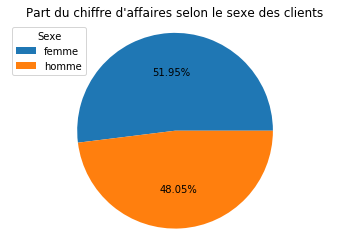

In [115]:
# Aggrégation des résultats des clients particuliers selon leur sexe
data_particuliers = data.loc[data.sex != 'pro']
achats_sexe = data_particuliers.groupby('sex').sum()

# Réalisation d'un diagramme en secteur
plt.pie(achats_sexe.price, autopct='%.2f%%')
plt.legend(['femme', 'homme'], title='Sexe', loc='upper left', fontsize=10)
plt.axis('equal')
plt.title('Part du chiffre d\'affaires selon le sexe des clients')
plt.savefig('Part du chiffre d\'affaires selon le sexe des clients.png')
plt.show()

In [116]:
# Affichage du tableau de contingence:
X = "sex"
Y = "categ"

cont = data_particuliers[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len).fillna(0).copy().astype(int)
cont

categ,0,1,2
sex,,,
f,101206,53774,8122
m,94064,48851,7634


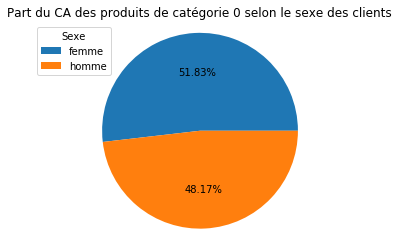

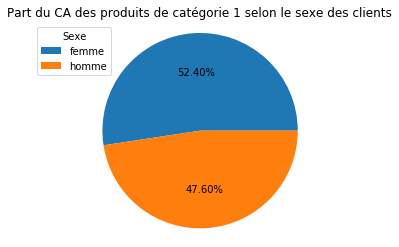

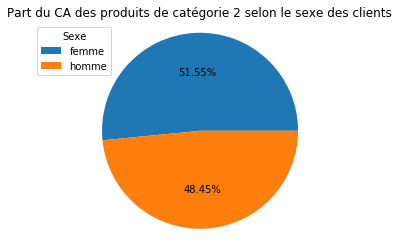

In [117]:
# Diagrammes en secteur pour chaque catégorie
for column in cont.columns[0:]:
    plt.pie(cont[column], autopct='%.2f%%')
    plt.legend(['femme', 'homme'], title='Sexe', loc='upper left', fontsize=10)
    plt.axis('equal')
    plt.title('Part du CA des produits de catégorie {} selon le sexe des clients'.format(column))
    plt.savefig('CA_sexe categ{}.png'.format(column))
    plt.show()

In [118]:
# Création d'un tableau de contingence
X = "sex"
Y = "categ"
cont = data_particuliers[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=False)

# Test d'indépendance Chi2
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(cont)
print("Chi2 :", st_chi2)
print("P-valeur :", st_p)
print("Degré de liberté :", st_dof)
print("Test Chi2  d'indépendance des variables du tableau de contingence: \n", st_exp)

Chi2 : 10.110865513726571
P-valeur : 0.006374607510181767
Degré de liberté : 2
Test Chi2  d'indépendance des variables du tableau de contingence: 
 [[101542.56654689  53366.13863817   8193.29481494]
 [ 93727.43345311  49258.86136183   7562.70518506]]


La p-valeur de 0.006 est bien inférieure à 0.05. Elle suggère que l'hypothèse d'indépendance entre les variables "sexe" et "catégories" peut être rejetée. Une corrélation est donc possible.

#### Création d'un tableau de contingence coloré

In [119]:
# Création d'un tableau de contingence qui intègre les totaux
cont = data_particuliers[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

cont

categ,0,1,2,Total
sex,,,,
f,101206,53774,8122,163102
m,94064,48851,7634,150549
Total,195270,102625,15756,313651


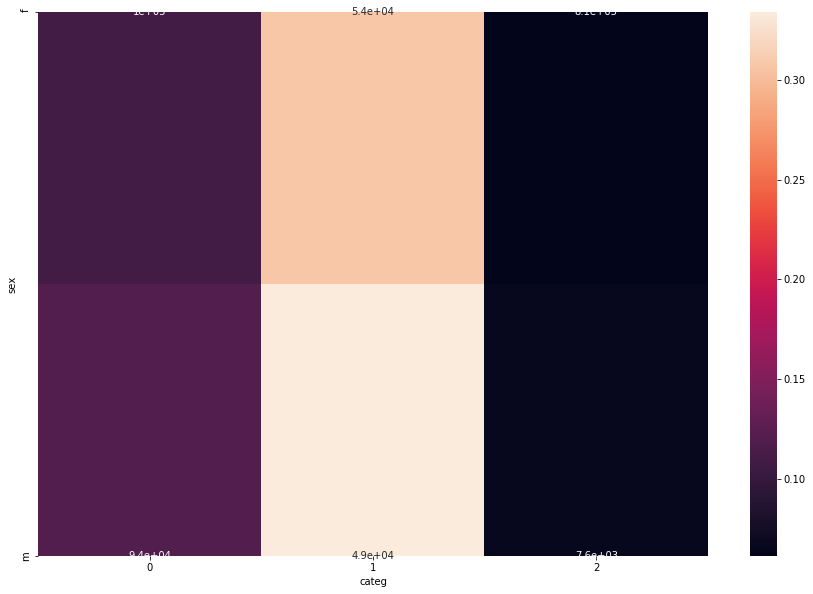

xi_n = 10.11086551372657


In [120]:
# Calcul du tableau 
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data_particuliers)
indep = tx.dot(ty) / n


plt.figure(figsize = (15,10))
c = cont.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()

print("xi_n =", xi_n)

Le tableau montre que le sexe des clients est davantage corrélé avec les produits de catégorie 2 qu'avec les produits de catégorie 1, et de manière plus contrastée avec les produits de catégorie 0.

In [121]:
# Test de Cramer
V = math.sqrt((xi_n**2)/(len(data_particuliers)*1))
print('V de Cramer:', V)

V de Cramer: 0.0180536490381123


Le V de Cramer étant largement inférieure à 0.10, l'intensité de la relation entre le sexe des clients et la catégorie des produits achetés est toutefois très faible.

### 4.8 L'âge des clients et le montant total des achats <a class='anchor' id='montant_total_age'></a>

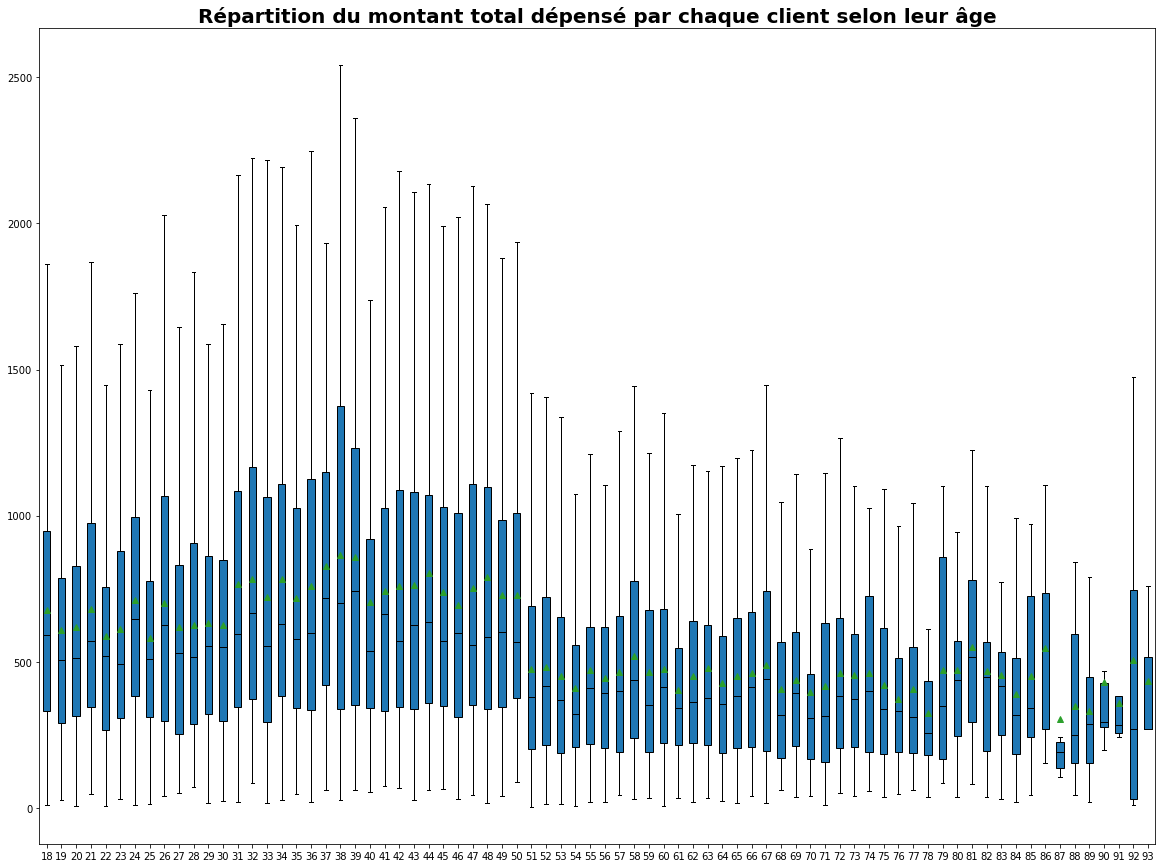

In [122]:
# Aggrégation par client de la base de données
CA_client = data_particuliers.groupby('client_id', as_index=False).first()
CA_client['price'] = data_particuliers.groupby('client_id', as_index=False)['price'].sum()['price']

# Paramétrage des données
plt.figure(figsize = (20,15))
modalites = np.sort(CA_client['client_age'].unique().astype(int))
groupes = []
for m in modalites:
    groupes.append(CA_client[CA_client['client_age']==m]['price'])

# Mise en forme
medianprops = {'color':'black', 'markerfacecolor':'firebrick'}
plt.boxplot(groupes, labels=modalites, medianprops=medianprops, showfliers=False,patch_artist=True, showmeans=True)
plt.title('Répartition du montant total dépensé par chaque client selon leur âge', fontsize=20, fontweight='bold')
plt.savefig('Répartition du montant total dépensé par chaque client selon leur âge.png')
plt.show()

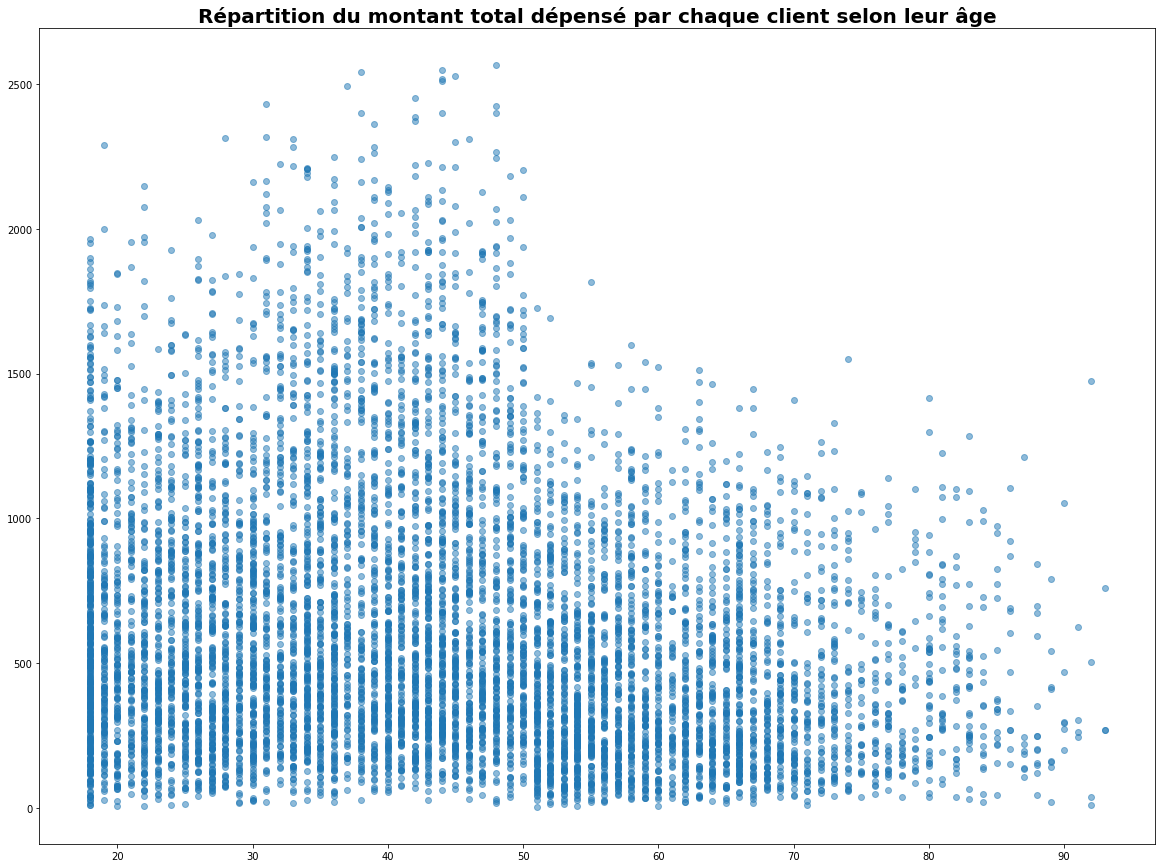

In [123]:
# Nuage de points
plt.figure(figsize = (20,15))
plt.plot(CA_client.client_age, CA_client.price, 'o', alpha=0.5)
plt.title('Répartition du montant total dépensé par chaque client selon leur âge', fontsize=20, fontweight='bold')
plt.show()

Les graphiques présentent des résultats très similaires et distinguent 2 principales catégories d'âge: un premier groupe qui a entre 18 et 50 ans et dont la majorité des dépenses oscille entre 400 et 900, puis un deuxième groupe (supérieur à 51 ans) dont la majorité des dépenses varie entre 200 et 600.

In [124]:
# Coefficient de corrélation de Pearson
print("Coefficient de corrélation linéaire:", st.pearsonr(CA_client.price, CA_client.client_age)[0])
print("Matrice de covariance:", np.cov(CA_client.price, CA_client.client_age, ddof=0)[1,0])

Coefficient de corrélation linéaire: -0.19036092308665029
Matrice de covariance: -1471.4425747585474


Avec un coefficient de corrélation linéaire proche de 0, l'âge et le montant des dépenses des clients sont peu corrélées.


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     323.1
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           5.94e-71
Time:                        11:10:17   Log-Likelihood:                -64689.
No. Observations:                8596   AIC:                         1.294e+05
Df Residuals:                    8594   BIC:                         1.294e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
client_age    -5.1461      0.286    -17.976      0.0

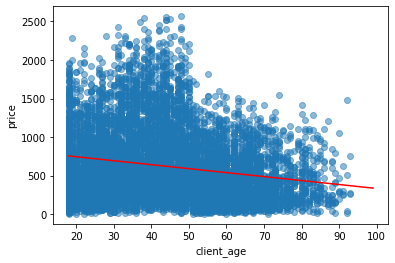

In [125]:
# Méthode des Moindres Carrés
Y = CA_client['price']
X = CA_client[['client_age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
print(result.summary())
a,b = result.params['client_age'],result.params['intercept']

# Paramétrage de la droite
plt.plot(CA_client.client_age,CA_client.price, "o", alpha=0.5)
plt.plot(np.arange(18,100),[a*x+b for x in np.arange(18,100)], color='red')
plt.xlabel("client_age")
plt.ylabel("price")
plt.show()

### Corrélation entre les dépenses et la tranche d'âge des clients

#### Dissociation des clients selon leur appartenance à un groupe de + ou - de 50 ans

Le tableau qui énumérait les clients par âge montrait que leur nombre était anormalement élevé pour ceux ayant 18 ans. Pour assurer la fiabilité de nos données, nous allons donc momentanément extraire ces clients de notre analyse

In [126]:
# Création d'une colonne associant les clients dits "particuliers" à leur tranche d'âge d'appartenance
bins = [18, 51, 120]
labels = ['19 à 50 ans', '51 ans et +']
CA_client['age_range'] = pd.cut(CA_client.client_age, bins, labels = labels, include_lowest=True)

# Classification des clients en 2 tranches d'âge (+ ou - de 50 ans)
CA_clients_jeunes = CA_client.loc[CA_client.age_range == '19 à 50 ans']
CA_clients_vieux = CA_client.loc[CA_client.age_range == '51 ans et +']

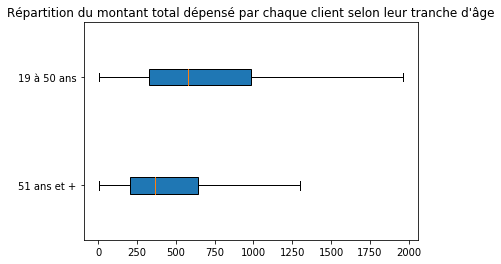

In [127]:
# Répartition des montants dépensés selon la tranche d'âge des clients
ages = CA_client.age_range.unique().dropna()
groupes = []
for age in ages:
    groupes.append(CA_client[CA_client.age_range==age]['price'])

plt.boxplot(groupes, labels = ages, showfliers=False, vert=False, patch_artist=True)
plt.title('Répartition du montant total dépensé par chaque client selon leur tranche d\'âge')
plt.savefig("Répartition du montant total dépensé par chaque client selon leur tranche d\'âge.png")
plt.show()

Les boîtes à moustache confirment une répartition des dépenses très différenciées entre les clients de 50 ans et moins d'une part et les clients ayant plus de 50 ans d'autre part.

In [128]:
# eta carré
x = "age_range"
y = "price" 

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print("L'eta carré est de :", eta_squared(CA_client["age_range"],CA_client["price"]))

L'eta carré est de : 0.06926058151888444


Si on se réfère aux balises de Cohen, l'effet de l'âge sur le niveau des dépenses est d'une intensité plutôt moyenne.

#### Analyse des montants dépensés par les clients ayant entre 19 et 50 ans:


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     25.78
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           3.94e-07
Time:                        11:10:18   Log-Likelihood:                -44077.
No. Observations:                5792   AIC:                         8.816e+04
Df Residuals:                    5790   BIC:                         8.817e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
client_age     3.2439      0.639      5.078      0.0

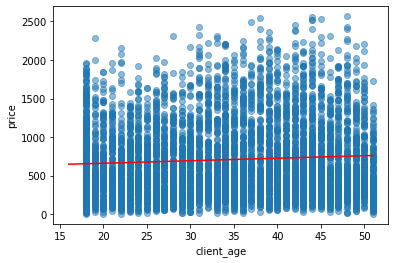

In [129]:
# Méthode des Moindres Carrés
Y = CA_clients_jeunes['price']
X = CA_clients_jeunes[['client_age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
print(result.summary())
a,b = result.params['client_age'],result.params['intercept']

# Paramétrage de la droite
plt.plot(CA_clients_jeunes.client_age,CA_clients_jeunes.price, "o", alpha=0.5)
plt.plot(np.arange(16,52),[a*x+b for x in np.arange(16,52)], color='red')
plt.xlabel("client_age")
plt.ylabel("price")
plt.show()

La p-valeur étant bien en-dessous de 0.05, l'hypothèse d'indépendance des variables âge et montant des dépenses peut être rejetée. Pour les clients de moins de 50 ans, l'âge et les montant dépensé sont corrélés mais très partiellement car l'âge n'explique que 0,4% du prix (R² étant égal à 0.004).

#### Analyse du chiffre d'affaires généré par les clients ayant plus de 50 ans

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.617
Date:                Mon, 11 Jan 2021   Prob (F-statistic):              0.106
Time:                        11:10:18   Log-Likelihood:                -20138.
No. Observations:                2804   AIC:                         4.028e+04
Df Residuals:                    2802   BIC:                         4.029e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
client_age    -1.0739      0.664     -1.618      0.1

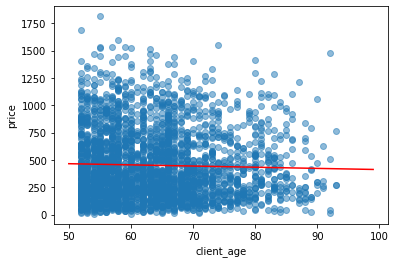

In [130]:
# Méthode des Moindres Carrés
Y = CA_clients_vieux['price']
X = CA_clients_vieux[['client_age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
print(result.summary())
a,b = result.params['client_age'],result.params['intercept']

# Paramétrage de la droite
plt.plot(CA_clients_vieux.client_age,CA_clients_vieux.price, "o", alpha=0.5)
plt.plot(np.arange(50,100),[a*x+b for x in np.arange(50,100)], color='red')
plt.xlabel("client_age")
plt.ylabel("price")
plt.show()

La p-valeur de 0.106 est supérieure à 0.05. L'hypothèse d'indépendance entre l'âge des clients de +50 ans et les montants leurs dépenses ne peut donc être rejetée. Il n'y a donc pas de corrélation.

### 4.9 Corrélation entre âge et montant des paniers <a class='anchor' id='paniers_age'></a>

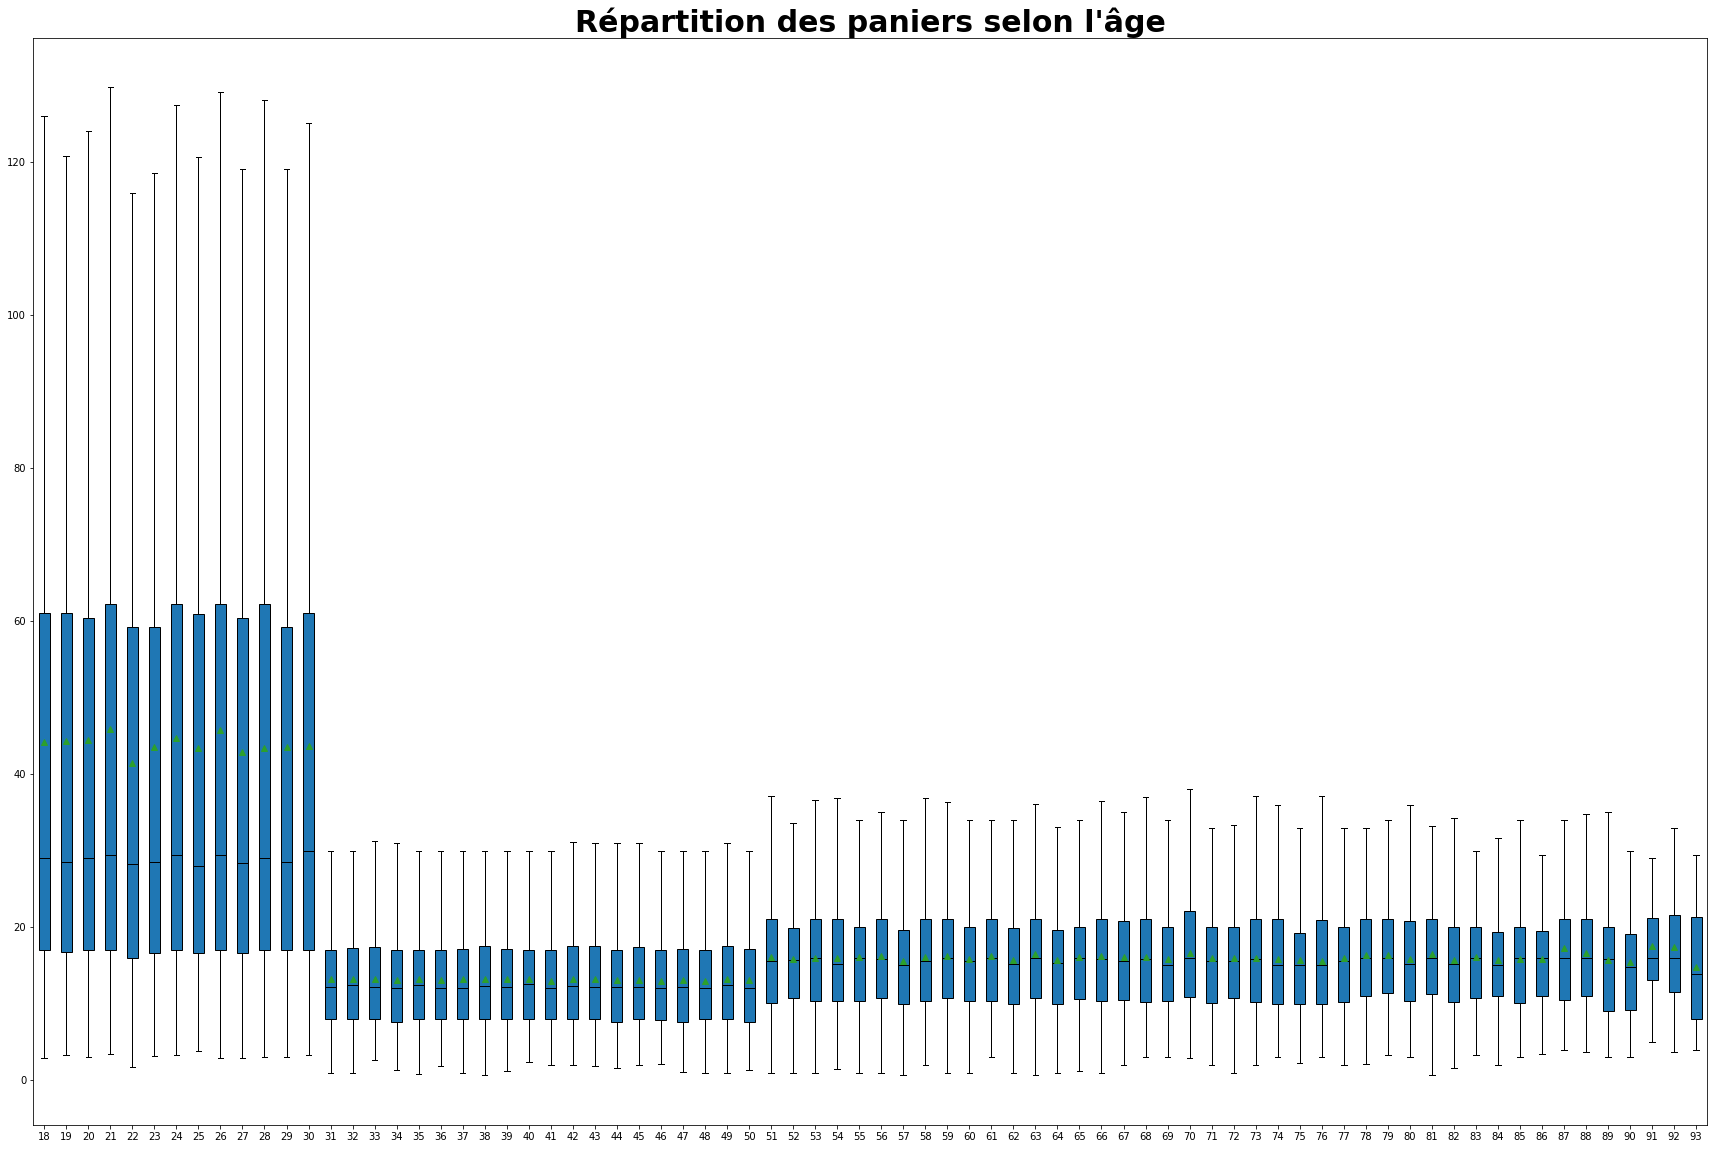

In [131]:
# Aggrégation par client de la base de données
data_sessions = data_particuliers.groupby('session_id', as_index=False).first()
data_sessions['price'] = data_sessions.groupby('session_id', as_index=False)['price'].sum()['price']

# Paramétrage des données
plt.figure(figsize = (30,20))
modalites = np.sort(data_sessions['client_age'].unique().astype(int))
groupes = []
for m in modalites:
    groupes.append(data_sessions[data_sessions['client_age']==m]['price'])

# Mise en forme
medianprops = {'color':'black', 'markerfacecolor':'firebrick'}
plt.boxplot(groupes, labels=modalites, medianprops=medianprops, showfliers=False,patch_artist=True, showmeans=True)
plt.title('Répartition des paniers selon l\'âge', fontsize=30, fontweight='bold')
plt.savefig('Répartition des paniers selon l\'âge.png')
plt.show()

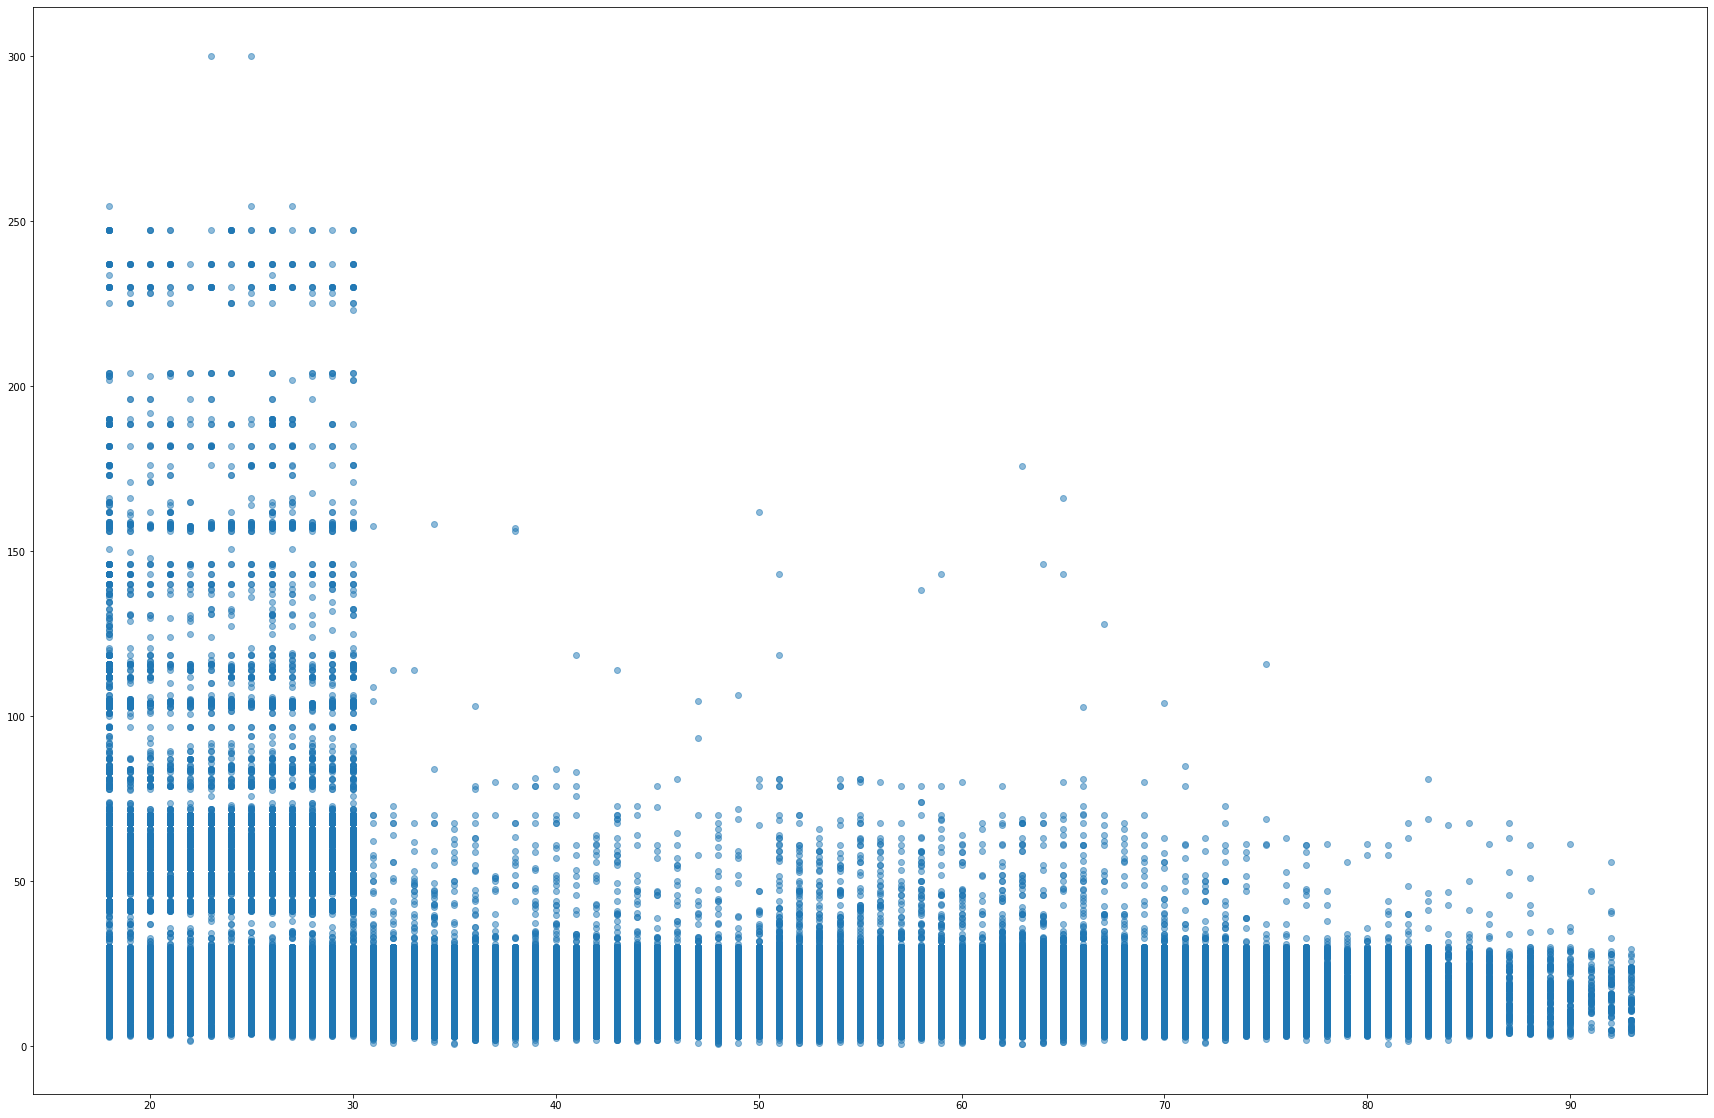

In [132]:
plt.figure(figsize = (30,20))
plt.plot(data_sessions.client_age, data_sessions.price, 'o', alpha=0.5)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        11:10:22   Log-Likelihood:            -6.7746e+05
No. Observations:              157808   AIC:                         1.355e+06
Df Residuals:                  157806   BIC:                         1.355e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
client_age    -0.3260      0.003   -110.677      0.0

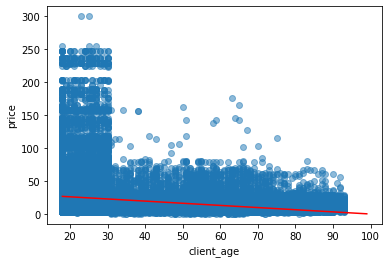

In [133]:
# Méthode des Moindres Carrés
Y = data_sessions['price']
X = data_sessions[['client_age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
print(result.summary())
a,b = result.params['client_age'],result.params['intercept']

# Paramétrage de la droite
plt.plot(data_sessions.client_age,data_sessions.price, "o", alpha=0.5)
plt.plot(np.arange(18,100),[a*x+b for x in np.arange(18,100)], color='red')
plt.xlabel("client_age")
plt.ylabel("price")
plt.show()

Les graphiques montrent une répartiton des montants très différenciée selon l'âge avec un très net contraste entre les clients ayant moins de 30 ans et ceux ayant plus de 30 ans.

In [134]:
# Réalisation de l'ANOVA
anova_age_categ = smf.ols('price ~ client_age', data=CA_client).fit()
print(anova_age_categ.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     323.1
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           5.94e-71
Time:                        11:10:23   Log-Likelihood:                -64689.
No. Observations:                8596   AIC:                         1.294e+05
Df Residuals:                    8594   BIC:                         1.294e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    849.0807     13.425     63.247      0.0

La p-valeur étant bien inférieure à 0,05, l'hypothèse nulle d'indépendance des variables peut etre rejetée. Avec un R² de 0,036, on peut déduire que l'âge a cependant 3,6% de probabilité seulement d'influencer le montant des paniers.

In [135]:
# Tableau d'analyse de la variance
sm.stats.anova_lm(anova_age_categ)

,df,sum_sq,mean_sq,F,PR(>F)
client_age,1.0,6.509064e+07,6.509064e+07,323.132642,5.936564e-71
Residual,8594.0,1.731143e+09,2.014363e+05,NaN,NaN


#### Corrélation entre le montant des paniers et la tranche d'âge

In [136]:
# Classification des clients en 2 tranches d'âge (+ ou - de 30 ans)
data_sessions_jeunes = data_sessions.loc[(data_sessions.client_age <=30) & (data_sessions.client_age>18)]
data_sessions_vieux = data_sessions.loc[data_sessions.client_age > 30]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5154
Date:                Mon, 11 Jan 2021   Prob (F-statistic):              0.473
Time:                        11:10:23   Log-Likelihood:                -82956.
No. Observations:               16425   AIC:                         1.659e+05
Df Residuals:                   16423   BIC:                         1.659e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
client_age    -0.0614      0.086     -0.718      0.4

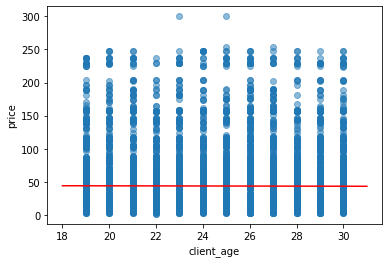

In [137]:
# Méthode des Moindres Carrés
Y = data_sessions_jeunes['price']
X = data_sessions_jeunes[['client_age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
print(result.summary())
a,b = result.params['client_age'],result.params['intercept']

# Paramétrage de la droite
plt.plot(data_sessions_jeunes.client_age,data_sessions_jeunes.price, "o", alpha=0.5)
plt.plot(np.arange(18,32),[a*x+b for x in np.arange(18,32)], color='red')
plt.xlabel("client_age")
plt.ylabel("price")
plt.show()

Le coefficient de corrélation est proche de 0, le R² est nul et la p-valeur est de 0.473. Il n'est donc pas possible d'exclure l'hypothèse d'indépendance entre les variables "âge" et "montant des paniers" pour les clients ayant entre 19 et 32 ans. Les chances de corrélation entre l'âge et le montant y sont donc très faibles.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3210.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        11:10:23   Log-Likelihood:            -4.7382e+05
No. Observations:              137201   AIC:                         9.477e+05
Df Residuals:                  137199   BIC:                         9.477e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
client_age     0.0892      0.002     56.661      0.0

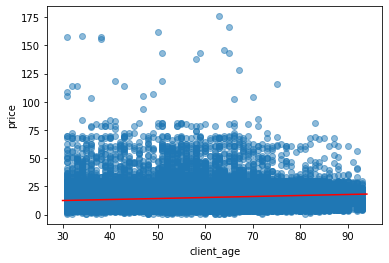

In [138]:
# Méthode des Moindres Carrés
Y = data_sessions_vieux['price']
X = data_sessions_vieux[['client_age']]
X = X.copy()
X['intercept'] = 1.
result = sm.OLS(Y, X).fit()
print(result.summary())
a,b = result.params['client_age'],result.params['intercept']

# Paramétrage de la droite
plt.plot(data_sessions_vieux.client_age,data_sessions_vieux.price, "o", alpha=0.5)
plt.plot(np.arange(30,95),[a*x+b for x in np.arange(30,95)], color='red')
plt.xlabel("client_age")
plt.ylabel("price")
plt.show()

Avec une p-valeur proche de 0, le montant des paniers et l'âge des clients peuvent être corrélées. Toutefois avec un R² de 0.02, l'âge des clients de plus de 32 ans semble n'avoir une incidence que de 2% sur le montant des paniers.

### 4.10 L'âge des clients et la catégorie des produits<a class='anchor' id='categ_age'></a>

#### Intervalle d'âge des clients acquéreurs de produits pour chacune des trois catégories

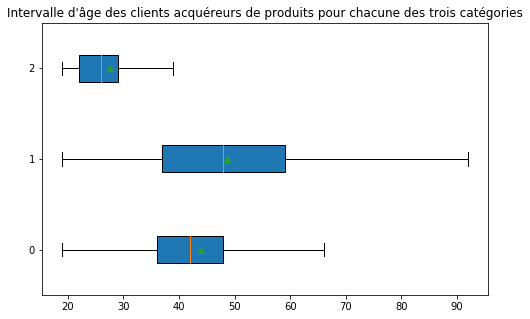

In [139]:
# Exclusion des clients ayant 18 ans et moins
data_particuliers_plus_18 = data_particuliers.loc[data_particuliers.client_age > 18]

# Boxplot
X = "categ"
Y = "client_age"

modalites = data_particuliers_plus_18[X].unique()
groupes = []

for m in modalites:
    groupes.append(data_particuliers_plus_18[data_particuliers_plus_18[X] == m][Y])

plt.figure(figsize = (8,5))
plt.boxplot(groupes, labels=modalites, showfliers=False, vert=False, patch_artist=True, showmeans=True)
plt.title('Intervalle d\'âge des clients acquéreurs de produits pour chacune des trois catégories')
plt.savefig('Intervalle d\'âge des clients acquéreurs de produits pour chacune des trois catégories.png')
plt.show()

Le graphique montre une nette concentration des achats de produits de catégorie 2 auprès des clients jeunes, alors que les produits de catégorie 1 semblent toucher une clientèle d'âge plus varié.

In [140]:
# Exclusion des clients ayant 18 ans et moins
CA_client_plus_18 = CA_client.loc[CA_client.client_age > 18]

# eta carré
X = "categ"
Y = "client_age"

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

print("L'eta carré est de :", eta_squared(CA_client_plus_18[X],CA_client_plus_18[Y]))

L'eta carré est de : 0.05784077480788334


Si on se réfère aux balises de Cohen, l'effet de l'âge sur la catégorie des produits achetés est d'une intensité plutôt moyenne.

In [141]:
# Réalisation de l'ANOVA
anova_age_categ = smf.ols('client_age ~ categ', data=CA_client).fit()
print(anova_age_categ.summary())

                            OLS Regression Results                            
Dep. Variable:             client_age   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     278.8
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          4.72e-118
Time:                        11:10:24   Log-Likelihood:                -36235.
No. Observations:                8596   AIC:                         7.248e+04
Df Residuals:                    8593   BIC:                         7.250e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.0597      0.243    185.517      0.0

In [142]:
# Tableau d'analyse de la variance
sm.stats.anova_lm(anova_age_categ)

,df,sum_sq,mean_sq,F,PR(>F)
categ,2.0,1.497870e+05,74893.506729,278.827385,4.719886e-118
Residual,8593.0,2.308094e+06,268.601689,NaN,NaN


## 4.11 L'âge des clients et la fréquence d'achat

In [143]:
freq_session_age = data_particuliers.groupby('client_id').agg({'session_id' : 'nunique', 'client_age' : 'mean'})
freq_session_age

,session_id,client_age
client_id,,
c_1,15,67.0
c_10,16,66.0
c_100,3,30.0
c_1000,42,56.0
c_1001,24,40.0
...,...,...
c_995,5,67.0
c_996,36,52.0
c_997,10,28.0


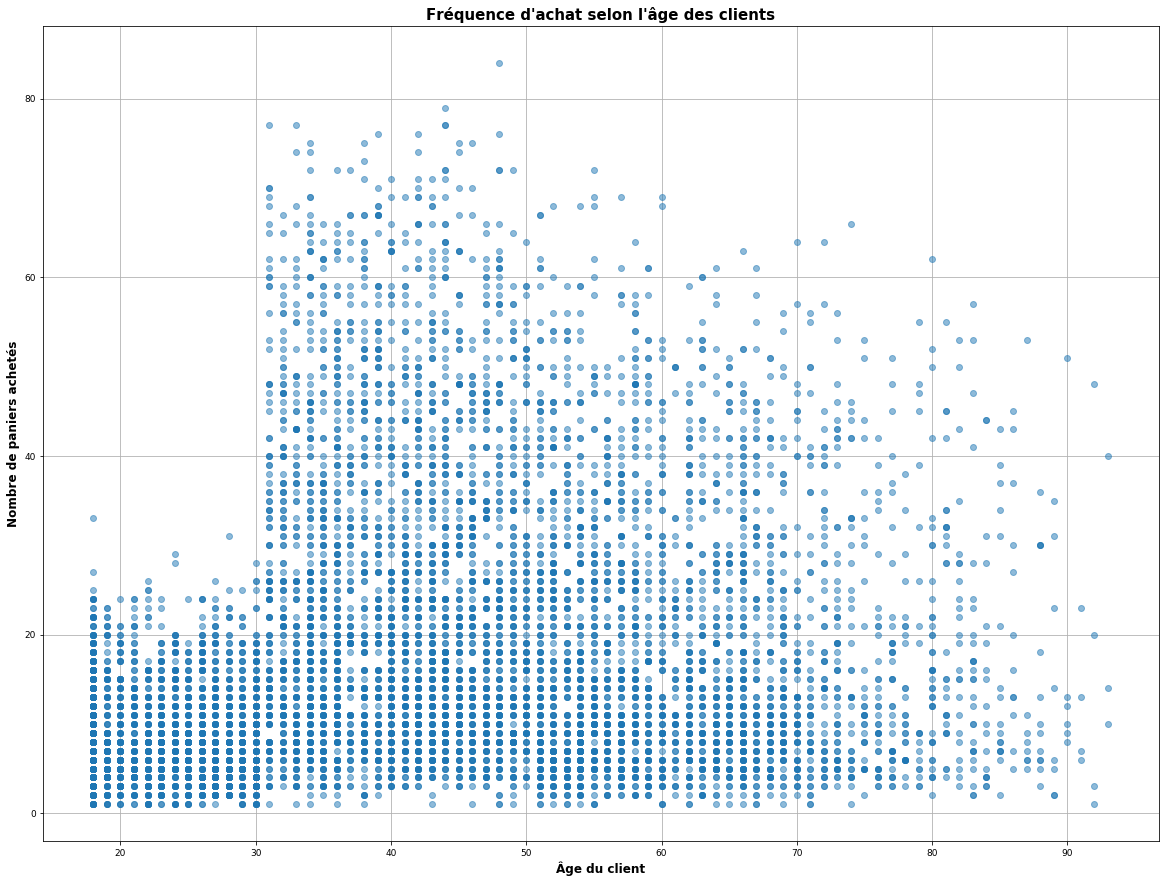

In [144]:
# Aspect du graphique
plt.figure(figsize=(20,15))
plt.plot(freq_session_age.client_age, freq_session_age.session_id, 'o', alpha=0.5)
plt.xlabel('Âge du client', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de paniers achetés', fontsize=12, fontweight='bold')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True)
plt.title('Fréquence d\'achat selon l\'âge des clients', fontsize=15, fontweight='bold')
plt.savefig('Fréquence d\'achat selon l\'âge des clients.png')
plt.show()

In [145]:
# Coefficient de corrélation de Pearson
print("Coefficient de corrélation linéaire:", st.pearsonr(freq_session_age.session_id, freq_session_age.client_age)[0])

Coefficient de corrélation linéaire: 0.16783790814631


Avec un coefficient de corrélation linéaire proche de 0, l'âge et la fréquence des achats sont peu corrélés. Le nuage de points montre toutefois un contraste important dans la fréquence d'achat entre les moins de 30 ans et les plus de 30 ans. Afin d'affiner notre analyse, nous allons donc dissocier notre analyse entre ces deux groupes d'âge.

#### Dissociation des clients selon leur appartenance à un groupe de + ou - de 30 ans

Le tableau qui énumérait les clients par âge montrait que leur nombre était anormalement élevé pour ceux ayant 18 ans. Pour assurer la fiabilité de nos données, nous allons donc momentanément extraire ces clients de notre analyse

In [146]:
# Création d'une colonne associant les clients dits "particuliers" à leur tranche d'âge d'appartenance
bins = [18, 30, 120]
labels = ['19 à 30 ans', '31 ans et +']
freq_session_age['age_range'] = pd.cut(freq_session_age.client_age, bins, labels = labels, include_lowest=True)

# Classification des clients en 2 tranches d'âge (+ ou - de 50 ans)
freq_clients_jeunes = freq_session_age.loc[freq_session_age.age_range == '19 à 30 ans']
freq_clients_vieux = freq_session_age.loc[freq_session_age.age_range == '31 ans et +']

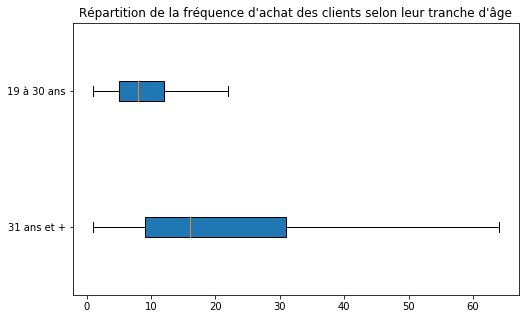

In [147]:
# Répartition des montants dépensés selon la tranche d'âge des clients
ages = freq_session_age['age_range'].unique().dropna()
groupes = []
for age in ages:
    groupes.append(freq_session_age[freq_session_age['age_range']==age]['session_id'])

plt.figure(figsize=(8,5))
plt.boxplot(groupes, labels = ages, showfliers=False, vert=False, patch_artist=True)
plt.title('Répartition de la fréquence d\'achat des clients selon leur tranche d\'âge')
plt.savefig('Répartition de la fréquence d\'achat des clients selon leur tranche d\'âge.png')
plt.show()

Les boîtes à moustache confirment une répartition de la fréquence d'achat différenciée entre les clients de 30 ans et moins d'une part et les clients de plus de 30 ans d'autre part.

In [148]:
# Calcul de l'eta carré
x = "age_range"
y = "session_id" 

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print("L'eta carré est de :", eta_squared(freq_session_age["age_range"],freq_session_age["session_id"]))

L'eta carré est de : 0.13313008604052684


Si on se réfère aux balises de Cohen, avec un eta carré de 0.13, l'effet de l'âge sur la fréquence d'achat est d'une intensité relativement importante.

## 4.12. L'âge des clients et la taille des paniers

In [149]:
# Aggrégation des données par session
nb_produits_session = data_particuliers.groupby(['session_id', 'client_id']).agg({'id_prod' : 'count', 'client_age' : 'mean'})
nb_produits_session

,,id_prod,client_age
session_id,client_id,,
s_1,c_329,1,55.0
s_10,c_2218,1,52.0
s_100,c_3854,2,44.0
s_1000,c_1014,4,33.0
s_10000,c_476,3,33.0
...,...,...,...
s_99994,c_7685,3,39.0
s_99995,c_4170,1,62.0
s_99996,c_4900,4,48.0


In [150]:
# Aggrégation des données par client
nb_produits_client = nb_produits_session.groupby('client_id').agg({'id_prod' : 'mean', 'client_age' : 'mean'})
nb_produits_client

,id_prod,client_age
client_id,,
c_1,1.333333,67.0
c_10,1.750000,66.0
c_100,2.000000,30.0
c_1000,1.333333,56.0
c_1001,2.416667,40.0
...,...,...
c_995,1.600000,67.0
c_996,1.166667,52.0
c_997,2.300000,28.0


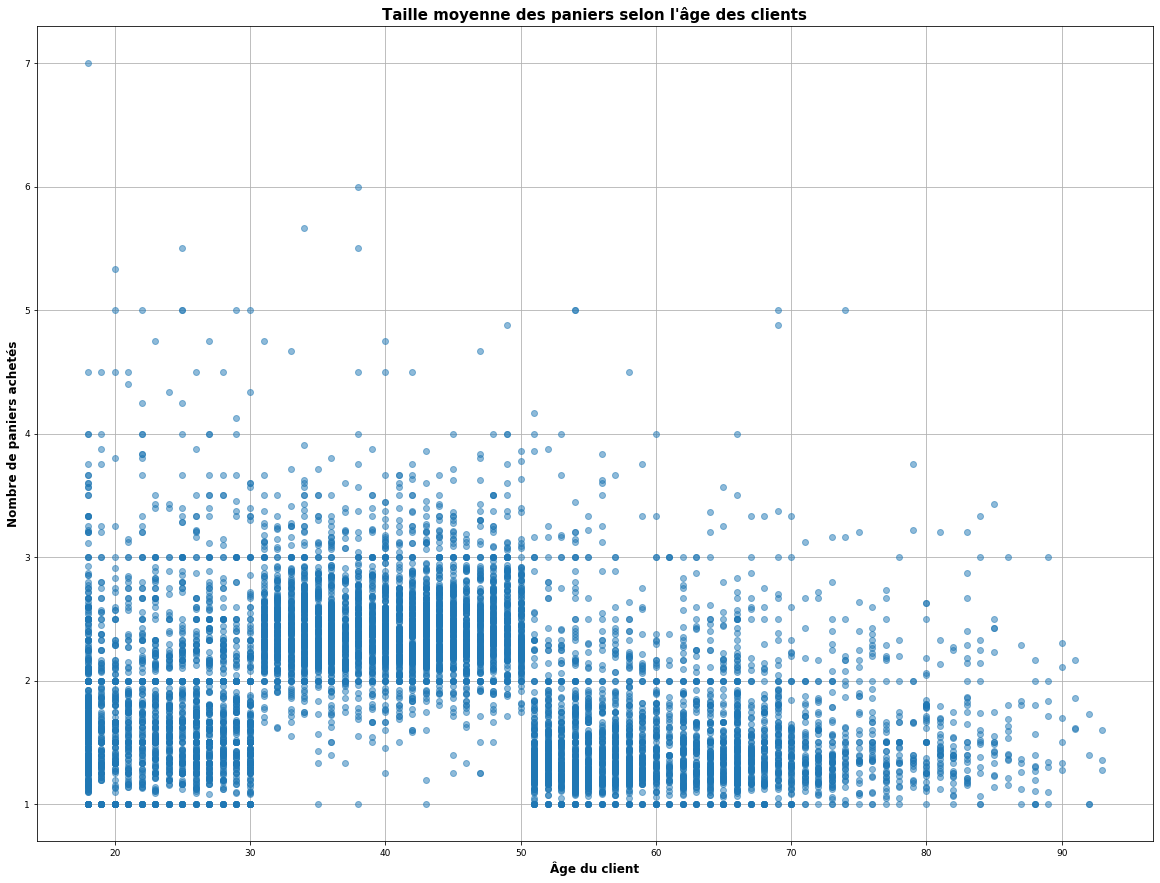

In [151]:
# Aspect du graphique
plt.figure(figsize=(20,15))
plt.plot(nb_produits_client.client_age, nb_produits_client.id_prod, 'o', alpha=0.5)
plt.xlabel('Âge du client', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de paniers achetés', fontsize=12, fontweight='bold')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True)
plt.title('Taille moyenne des paniers selon l\'âge des clients', fontsize=15, fontweight='bold')
plt.savefig('Taille moyenne des paniers selon l\'âge des clients.png')
plt.show()

In [152]:
# Création d'une colonne associant les clients à leur tranche d'âge d'appartenance
bins = [18, 30, 50, 120]
labels = ['19 à 30 ans', '31 à 50 ans', '51 ans et +']
nb_produits_client['age_range'] = pd.cut(nb_produits_client.client_age, bins, labels = labels, include_lowest=True)

# Classification des clients en 3 tranches d'âge
freq_clients_jeunes = freq_session_age.loc[freq_session_age.age_range == '19 à 30 ans']
freq_clients_moyen = freq_session_age.loc[freq_session_age.age_range == '31 à 50 ans']
freq_clients_vieux = freq_session_age.loc[freq_session_age.age_range == '51 ans et +']

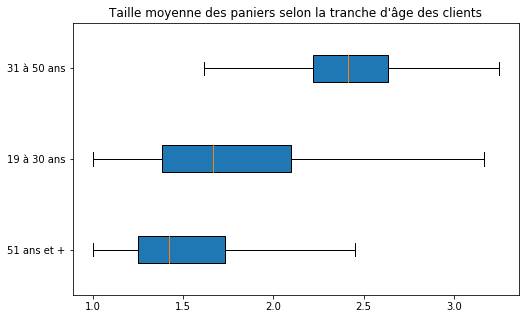

In [153]:
# Taille moyenne des paniers selon la tranche d\'âge des clients
ages = nb_produits_client['age_range'].unique().dropna()
groupes = []
for age in ages:
    groupes.append(nb_produits_client[nb_produits_client['age_range']==age]['id_prod'])

plt.figure(figsize=(8,5))
plt.boxplot(groupes, labels = ages, showfliers=False, vert=False, patch_artist=True)
plt.title('Taille moyenne des paniers selon la tranche d\'âge des clients')
plt.savefig('Taille moyenne des paniers selon la tranche d\'âge des clients.png')
plt.show()

In [154]:
# Coefficient de corrélation de Pearson
print("Coefficient de corrélation linéaire:", st.pearsonr(nb_produits_client.id_prod, nb_produits_client.client_age)[0])

Coefficient de corrélation linéaire: -0.2283526448587867


Avec un coefficient de corrélation linéaire proche de 0, l'âge des clients et la taille moyenne des paniers semblent peu corrélés. Nous savons toutefois que ce coefficient s'applique surtout aux données dont les points d'un nuage s'aggrègent en ligne droite. Or, si le nuage ne semble pas montrer une forte corrélation, il n'exprime pas moins une tendance qui mériterait d'être analysée en échantillonnant les données par tranche d'âge, comme nous l'avons fait dans la partie 2.1.